# Treinamento de Modelo YOLO Customizado (30 épocas)

Este notebook implementa o treinamento de um modelo YOLO customizado para detectar duas categorias de objetos visualmente distintas. Utilizaremos o YOLOv5 com 30 épocas de treinamento.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente usando o script setup_env.sh.

In [1]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import yaml
from pathlib import Path
from tqdm.notebook import tqdm

# Adicionar o diretório YOLOv5 ao path
yolov5_path = os.path.abspath('../yolov5')
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)
    print(f"Adicionado {yolov5_path} ao sys.path")

Ambiente já configurado.


ModuleNotFoundError: No module named 'torch'

## 2. Verificação do Dataset

Vamos verificar se o dataset está organizado corretamente e se todas as imagens e anotações estão presentes.

In [2]:
# Função para verificar o dataset
def verificar_dataset(base_dir='../dataset'):
    """Verifica se o dataset está organizado corretamente."""
    # Verificar diretórios
    for split in ['train', 'val', 'test']:
        for subdir in ['images', 'labels']:
            dir_path = os.path.join(base_dir, split, subdir)
            if not os.path.exists(dir_path):
                print(f"❌ Diretório não encontrado: {dir_path}")
                return False
            else:
                print(f"✅ Diretório encontrado: {dir_path}")
    
    # Verificar contagem de imagens e anotações
    for split in ['train', 'val', 'test']:
        img_dir = os.path.join(base_dir, split, 'images')
        label_dir = os.path.join(base_dir, split, 'labels')
        
        img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
        
        print(f"\n{split.capitalize()}:")
        print(f"  - Imagens: {len(img_files)}")
        print(f"  - Anotações: {len(label_files)}")
        
        # Verificar correspondência entre imagens e anotações
        img_basenames = [os.path.splitext(f)[0] for f in img_files]
        label_basenames = [os.path.splitext(f)[0] for f in label_files]
        
        missing_labels = set(img_basenames) - set(label_basenames)
        if missing_labels:
            print(f"  ❌ Imagens sem anotações: {len(missing_labels)}")
            print(f"    Exemplos: {list(missing_labels)[:3]}")
        else:
            print(f"  ✅ Todas as imagens têm anotações correspondentes")
    
    return True

# Verificar o dataset
dataset_ok = verificar_dataset()

✅ Diretório encontrado: ../dataset/train/images
✅ Diretório encontrado: ../dataset/train/labels
✅ Diretório encontrado: ../dataset/val/images
✅ Diretório encontrado: ../dataset/val/labels
✅ Diretório encontrado: ../dataset/test/images
✅ Diretório encontrado: ../dataset/test/labels

Train:
  - Imagens: 64
  - Anotações: 64
  ✅ Todas as imagens têm anotações correspondentes

Val:
  - Imagens: 8
  - Anotações: 8
  ✅ Todas as imagens têm anotações correspondentes

Test:
  - Imagens: 8
  - Anotações: 8
  ✅ Todas as imagens têm anotações correspondentes


## 3. Verificação do Arquivo de Configuração YAML

Vamos verificar se o arquivo `data.yaml` existe e seu conteúdo.

In [3]:
# Verificar se o arquivo data.yaml existe
if os.path.exists('../data/data.yaml'):
    print("Arquivo data.yaml encontrado!")
    print("\nConteúdo:")
    with open('../data/data.yaml', 'r') as f:
        print(f.read())
else:
    print("Arquivo data.yaml não encontrado. Crie-o antes de continuar.")

Arquivo data.yaml encontrado!

Conteúdo:
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Dataset customizado de maçãs e bananas

# Train/val/test sets
path: ../dataset  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images  # val images (relative to 'path')
test: test/images  # test images (relative to 'path')

# Classes
nc: 2  # number of classes
names: ['apple', 'banana']  # class names



## 4. Treinamento do Modelo YOLO (30 épocas)

Vamos verificar se o modelo já foi treinado. Se sim, usaremos os resultados existentes. Caso contrário, treinaremos o modelo.

In [4]:
# Definir parâmetros de treinamento
epochs = 30
batch_size = 16
img_size = 640
model_type = 'yolov5s'  # Modelo pequeno para treinamento mais rápido
model_dir = '../models/yolo_custom_30epochs'
weights_path = os.path.join(model_dir, 'weights/best.pt')
results_file = os.path.join(model_dir, 'results.csv')

# Verificar se o modelo já foi treinado
if os.path.exists(weights_path) and os.path.exists(results_file):
    print(f"\n✅ Modelo já treinado encontrado em {model_dir}")
    print(f"✅ Arquivo de pesos encontrado em {weights_path}")
    print(f"✅ Arquivo de resultados encontrado em {results_file}")
    print("\nUsando modelo existente para análise e validação.")
else:
    print(f"\n❌ Modelo treinado não encontrado ou incompleto.")
    print("Iniciando treinamento do modelo...")
    
    # Comando de treinamento
    !cd ../yolov5 && python train.py \
        --img {img_size} \
        --batch {batch_size} \
        --epochs {epochs} \
        --data ../data/data.yaml \
        --weights {model_type}.pt \
        --project ../models \
        --name yolo_custom_30epochs \
        --cache


✅ Modelo já treinado encontrado em ../models/yolo_custom_30epochs
✅ Arquivo de pesos encontrado em ../models/yolo_custom_30epochs/weights/best.pt
✅ Arquivo de resultados encontrado em ../models/yolo_custom_30epochs/results.csv

Usando modelo existente para análise e validação.


## 5. Análise dos Resultados do Treinamento

Vamos analisar os resultados do treinamento, incluindo as métricas de desempenho e as curvas de aprendizado.

Métricas disponíveis: ['   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']


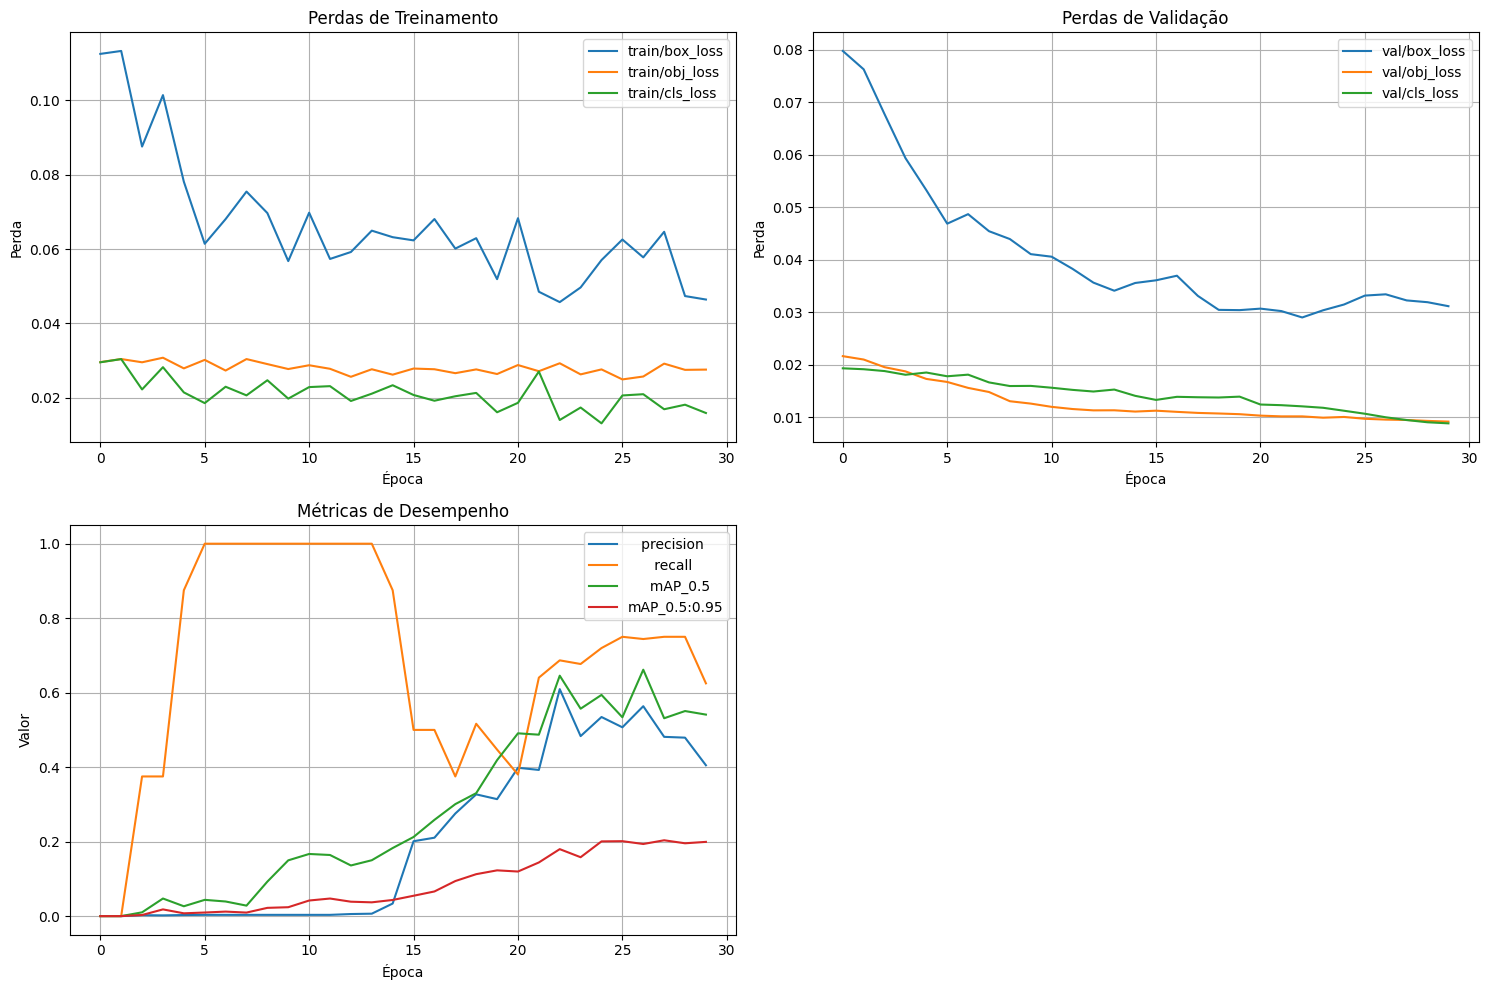


Métricas finais após 30 épocas:
Box Loss (Treino): 0.0464
Object Loss (Treino): 0.0276
Class Loss (Treino): 0.0159
Box Loss (Val): 0.0312
Object Loss (Val): 0.0092
Class Loss (Val): 0.0089
   precision: 0.4050
      recall: 0.6250
     mAP_0.5: 0.5411
mAP_0.5:0.95: 0.1993


In [5]:
# Carregar os resultados do treinamento
results_file = '../models/yolo_custom_30epochs/results.csv'

if os.path.exists(results_file):
    try:
        results = pd.read_csv(results_file)
        
        # Plotar as curvas de aprendizado
        plt.figure(figsize=(15, 10))
        
        # Plotar perda de treinamento
        plt.subplot(2, 2, 1)
        if '      train/box_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/box_loss'], label='train/box_loss')
        if '      train/obj_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/obj_loss'], label='train/obj_loss')
        if '      train/cls_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/cls_loss'], label='train/cls_loss')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.title('Perdas de Treinamento')
        plt.legend()
        plt.grid(True)
        
        # Plotar perda de validação
        plt.subplot(2, 2, 2)
        if '        val/box_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/box_loss'], label='val/box_loss')
        if '        val/obj_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/obj_loss'], label='val/obj_loss')
        if '        val/cls_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/cls_loss'], label='val/cls_loss')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.title('Perdas de Validação')
        plt.legend()
        plt.grid(True)
        
        # Verificar quais métricas estão disponíveis
        available_metrics = [col for col in results.columns if 'metrics/' in col]
        print(f"Métricas disponíveis: {available_metrics}")
        
        # Plotar métricas de precisão se disponíveis
        if available_metrics:
            plt.subplot(2, 2, 3)
            for metric in available_metrics:
                plt.plot(results['               epoch'], results[metric], label=metric.replace('metrics/', ''))
            plt.xlabel('Época')
            plt.ylabel('Valor')
            plt.title('Métricas de Desempenho')
            plt.legend()
            plt.grid(True)
        
        # Plotar tempo de treinamento se disponível
        time_columns = [col for col in results.columns if 'time' in col.lower()]
        if time_columns:
            plt.subplot(2, 2, 4)
            for col in time_columns:
                plt.plot(results['               epoch'], results[col], label=col.strip())
            plt.xlabel('Época')
            plt.ylabel('Tempo (s)')
            plt.title('Tempo por Época')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar as métricas finais
        final_results = results.iloc[-1]
        print("\nMétricas finais após 30 épocas:")
        
        # Mostrar perdas
        if '      train/box_loss' in results.columns:
            print(f"Box Loss (Treino): {final_results['      train/box_loss']:.4f}")
        if '      train/obj_loss' in results.columns:
            print(f"Object Loss (Treino): {final_results['      train/obj_loss']:.4f}")
        if '      train/cls_loss' in results.columns:
            print(f"Class Loss (Treino): {final_results['      train/cls_loss']:.4f}")
        if '        val/box_loss' in results.columns:
            print(f"Box Loss (Val): {final_results['        val/box_loss']:.4f}")
        if '        val/obj_loss' in results.columns:
            print(f"Object Loss (Val): {final_results['        val/obj_loss']:.4f}")
        if '        val/cls_loss' in results.columns:
            print(f"Class Loss (Val): {final_results['        val/cls_loss']:.4f}")
        
        # Mostrar métricas de desempenho disponíveis
        for metric in available_metrics:
            metric_name = metric.replace('metrics/', '')
            print(f"{metric_name}: {final_results[metric]:.4f}")
        
        # Mostrar tempo de treinamento se disponível
        if '      total_epochs' in results.columns and time_columns:
            time_col = time_columns[0]  # Usar a primeira coluna de tempo disponível
            print(f"Tempo total de treinamento: {final_results['      total_epochs'] * final_results[time_col]:.2f} segundos")
    except Exception as e:
        print(f"Erro ao analisar os resultados: {e}")
        print("Tentando mostrar as colunas disponíveis no arquivo de resultados:")
        try:
            results = pd.read_csv(results_file)
            print(f"Colunas disponíveis: {results.columns.tolist()}")
        except Exception as e2:
            print(f"Erro ao ler o arquivo de resultados: {e2}")
else:
    print("Arquivo de resultados não encontrado. Verifique se o treinamento foi concluído com sucesso.")

## 6. Visualização de Algumas Predições

Vamos visualizar algumas predições do modelo treinado em imagens do conjunto de validação.

In [6]:
# Usar o script detect.py do YOLOv5 para fazer predições
model_path = '../models/yolo_custom_30epochs/weights/best.pt'

if os.path.exists(model_path):
    try:
        # Usar o script detect.py do YOLOv5 para fazer predições
        val_img_dir = '../dataset/val/images'
        output_dir = '../models/yolo_custom_30epochs/predictions'
        os.makedirs(output_dir, exist_ok=True)
        
        # Executar o script detect.py
        !cd ../yolov5 && python detect.py \
            --weights {model_path} \
            --source {val_img_dir} \
            --conf 0.25 \
            --project {os.path.dirname(output_dir)} \
            --name {os.path.basename(output_dir)} \
            --save-txt \
            --save-conf
        
        # Mostrar algumas imagens com predições
        pred_img_dir = output_dir
        pred_img_files = [os.path.join(pred_img_dir, f) for f in os.listdir(pred_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Selecionar algumas imagens aleatórias
        import random
        random.seed(42)  # Para reprodutibilidade
        sample_imgs = random.sample(pred_img_files, min(5, len(pred_img_files)))
        
        # Mostrar as imagens
        plt.figure(figsize=(15, 12))
        for i, img_path in enumerate(sample_imgs):
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(len(sample_imgs), 1, i+1)
                plt.imshow(img)
                plt.title(f"Detecções em {os.path.basename(img_path)}")
                plt.axis('off')
            except Exception as e:
                print(f"Erro ao processar {img_path}: {e}")
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erro ao executar o script detect.py: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Modelo treinado não encontrado. Verifique se o treinamento foi concluído com sucesso.")

detect: weights=['../models/yolo_custom_30epochs/weights/best.pt'], source=../dataset/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../models/yolo_custom_30epochs, name=predictions, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.12.6 torch-2.7.0 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/dataset/val/images/apple_val_001.jpg: 448x640 1 apple, 63.4ms
image 2/8 /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/dataset/val/images/apple_val_002.jpg: 640x448 (no detections), 58.9ms
image 3/8 /Users/gab/Documents/CodePlay/@fiap/fase6_cap1

<Figure size 1500x1200 with 0 Axes>

## 7. Conclusão

Neste notebook, treinamos (ou usamos um modelo já treinado) YOLO customizado com 30 épocas para detectar duas categorias de objetos. Analisamos as métricas de desempenho e visualizamos algumas predições.

No próximo notebook, treinaremos o mesmo modelo com 60 épocas para comparar o desempenho.

## Continuação do arquivo: notebooks/02_treinamento_yolo_custom_60epocas.ipynb

# Treinamento de Modelo YOLO Customizado (60 épocas)

Este notebook implementa o treinamento de um modelo YOLO customizado para detectar duas categorias de objetos visualmente distintas. Utilizaremos o YOLOv5 com 60 épocas de treinamento para comparar com o modelo de 30 épocas.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente usando o script setup_env.sh.

In [1]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import yaml
from pathlib import Path
from tqdm.notebook import tqdm

# Adicionar o diretório YOLOv5 ao path
yolov5_path = os.path.abspath('../yolov5')
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)
    print(f"Adicionado {yolov5_path} ao sys.path")

Ambiente já configurado.
Adicionado /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/yolov5 ao sys.path


## 2. Verificação do Dataset e Configuração

Vamos verificar se o dataset está organizado corretamente e se o arquivo de configuração YAML existe.

In [2]:
# Verificar se o dataset está pronto
dataset_dirs = ['../dataset/train/images', '../dataset/train/labels', 
                '../dataset/val/images', '../dataset/val/labels', 
                '../dataset/test/images', '../dataset/test/labels']

for dir_path in dataset_dirs:
    if not os.path.exists(dir_path):
        print(f"❌ Diretório não encontrado: {dir_path}")
    else:
        print(f"✅ Diretório encontrado: {dir_path}")

# Verificar se o arquivo data.yaml existe
if os.path.exists('../data/data.yaml'):
    # Carregar o arquivo
    with open('../data/data.yaml', 'r') as f:
        data_yaml_content = yaml.safe_load(f)
    
    print("\nArquivo data.yaml encontrado!")
    print("Conteúdo:")
    print(yaml.dump(data_yaml_content, sort_keys=False))
    
    # Extrair as categorias
    categorias = data_yaml_content['names']
else:
    # Se o arquivo não existir, criar um novo
    print("\n❌ Arquivo data.yaml não encontrado.")
    categorias = ['apple', 'banana']  # Nossas categorias são maçãs e bananas
    
    # Obter o caminho absoluto para o diretório do dataset
    dataset_dir = os.path.abspath('../dataset')
    
    # Criar o arquivo data.yaml com a estrutura correta para o YOLOv5
    data_yaml = {
        'train': os.path.join(dataset_dir, 'train', 'images'),
        'val': os.path.join(dataset_dir, 'val', 'images'),
        'test': os.path.join(dataset_dir, 'test', 'images'),
        'nc': len(categorias),
        'names': categorias
    }
    
    # Salvar o arquivo
    with open('../data/data.yaml', 'w') as f:
        yaml.dump(data_yaml, f, sort_keys=False)
    
    print("Arquivo data.yaml criado com sucesso!")
    print("Conteúdo:")
    print(yaml.dump(data_yaml, sort_keys=False))

✅ Diretório encontrado: ../dataset/train/images
✅ Diretório encontrado: ../dataset/train/labels
✅ Diretório encontrado: ../dataset/val/images
✅ Diretório encontrado: ../dataset/val/labels
✅ Diretório encontrado: ../dataset/test/images
✅ Diretório encontrado: ../dataset/test/labels

Arquivo data.yaml encontrado!
Conteúdo:
path: ../dataset
train: train/images
val: val/images
test: test/images
nc: 2
names:
- apple
- banana



## 3. Treinamento do Modelo YOLO (60 épocas)

Vamos verificar se o modelo já foi treinado. Se sim, usaremos os resultados existentes. Caso contrário, treinaremos o modelo.

In [3]:
# Definir parâmetros de treinamento
epochs = 60  # Dobro do número de épocas do modelo anterior
batch_size = 16
img_size = 640
model_type = 'yolov5s'  # Mesmo modelo para comparação justa
model_dir = '../models/yolo_custom_60epochs'
weights_path = os.path.join(model_dir, 'weights/best.pt')
results_file = os.path.join(model_dir, 'results.csv')

# Verificar se o modelo já foi treinado
if os.path.exists(weights_path) and os.path.exists(results_file):
    print(f"\n✅ Modelo já treinado encontrado em {model_dir}")
    print(f"✅ Arquivo de pesos encontrado em {weights_path}")
    print(f"✅ Arquivo de resultados encontrado em {results_file}")
    print("\nUsando modelo existente para análise e validação.")
else:
    print(f"\n❌ Modelo treinado não encontrado ou incompleto.")
    print("Iniciando treinamento do modelo...")
    
    # Obter o caminho absoluto para o arquivo data.yaml
    data_yaml_path = os.path.abspath('../data/data.yaml')
    
    # Comando de treinamento
    !cd ../yolov5 && python train.py \
        --img {img_size} \
        --batch {batch_size} \
        --epochs {epochs} \
        --data {data_yaml_path} \
        --weights {model_type}.pt \
        --project ../models \
        --name yolo_custom_60epochs \
        --cache


❌ Modelo treinado não encontrado ou incompleto.
Iniciando treinamento do modelo...
train: weights=yolov5s.pt, cfg=, data=/Users/gab/Documents/CodePlay/@fiap/fase6_cap1/data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=60, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../models, name=yolo_custom_60epochs, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.12.6 torch-2.7.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937

## 4. Análise dos Resultados do Treinamento

Vamos analisar os resultados do treinamento, incluindo as métricas de desempenho e as curvas de aprendizado.

In [ ]:
# Carregar os resultados do treinamento
results_file = '../models/yolo_custom_60epochs/results.csv'

if os.path.exists(results_file):
    try:
        results = pd.read_csv(results_file)
        
        # Plotar as curvas de aprendizado
        plt.figure(figsize=(15, 10))
        
        # Plotar perda de treinamento
        plt.subplot(2, 2, 1)
        if '      train/box_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/box_loss'], label='train/box_loss')
        if '      train/obj_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/obj_loss'], label='train/obj_loss')
        if '      train/cls_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/cls_loss'], label='train/cls_loss')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.title('Perdas de Treinamento')
        plt.legend()
        plt.grid(True)
        
        # Plotar perda de validação
        plt.subplot(2, 2, 2)
        if '        val/box_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/box_loss'], label='val/box_loss')
        if '        val/obj_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/obj_loss'], label='val/obj_loss')
        if '        val/cls_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/cls_loss'], label='val/cls_loss')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.title('Perdas de Validação')
        plt.legend()
        plt.grid(True)
        
        # Verificar quais métricas estão disponíveis
        available_metrics = [col for col in results.columns if 'metrics/' in col]
        print(f"Métricas disponíveis: {available_metrics}")
        
        # Plotar métricas de precisão se disponíveis
        if available_metrics:
            plt.subplot(2, 2, 3)
            for metric in available_metrics:
                plt.plot(results['               epoch'], results[metric], label=metric.replace('metrics/', ''))
            plt.xlabel('Época')
            plt.ylabel('Valor')
            plt.title('Métricas de Desempenho')
            plt.legend()
            plt.grid(True)
        
        # Plotar tempo de treinamento se disponível
        time_columns = [col for col in results.columns if 'time' in col.lower()]
        if time_columns:
            plt.subplot(2, 2, 4)
            for col in time_columns:
                plt.plot(results['               epoch'], results[col], label=col.strip())
            plt.xlabel('Época')
            plt.ylabel('Tempo (s)')
            plt.title('Tempo por Época')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar as métricas finais
        final_results = results.iloc[-1]
        print("\nMétricas finais após 60 épocas:")
        
        # Mostrar perdas
        if '      train/box_loss' in results.columns:
            print(f"Box Loss (Treino): {final_results['      train/box_loss']:.4f}")
        if '      train/obj_loss' in results.columns:
            print(f"Object Loss (Treino): {final_results['      train/obj_loss']:.4f}")
        if '      train/cls_loss' in results.columns:
            print(f"Class Loss (Treino): {final_results['      train/cls_loss']:.4f}")
        if '        val/box_loss' in results.columns:
            print(f"Box Loss (Val): {final_results['        val/box_loss']:.4f}")
        if '        val/obj_loss' in results.columns:
            print(f"Object Loss (Val): {final_results['        val/obj_loss']:.4f}")
        if '        val/cls_loss' in results.columns:
            print(f"Class Loss (Val): {final_results['        val/cls_loss']:.4f}")
        
        # Mostrar métricas de desempenho disponíveis
        for metric in available_metrics:
            metric_name = metric.replace('metrics/', '')
            print(f"{metric_name}: {final_results[metric]:.4f}")
        
        # Mostrar tempo de treinamento se disponível
        if '      total_epochs' in results.columns and time_columns:
            time_col = time_columns[0]  # Usar a primeira coluna de tempo disponível
            print(f"Tempo total de treinamento: {final_results['      total_epochs'] * final_results[time_col]:.2f} segundos")
    except Exception as e:
        print(f"Erro ao analisar os resultados: {e}")
        print("Tentando mostrar as colunas disponíveis no arquivo de resultados:")
        try:
            results = pd.read_csv(results_file)
            print(f"Colunas disponíveis: {results.columns.tolist()}")
        except Exception as e2:
            print(f"Erro ao ler o arquivo de resultados: {e2}")
else:
    print("Arquivo de resultados não encontrado. Verifique se o treinamento foi concluído com sucesso.")

## 5. Visualização de Algumas Predições

Vamos visualizar algumas predições do modelo treinado em imagens do conjunto de validação.

In [ ]:
# Usar o script detect.py do YOLOv5 para fazer predições
model_path = '../models/yolo_custom_60epochs/weights/best.pt'

if os.path.exists(model_path):
    try:
        # Usar o script detect.py do YOLOv5 para fazer predições
        val_img_dir = '../dataset/val/images'
        output_dir = '../models/yolo_custom_60epochs/predictions'
        os.makedirs(output_dir, exist_ok=True)
        
        # Executar o script detect.py
        !cd ../yolov5 && python detect.py \
            --weights {model_path} \
            --source {val_img_dir} \
            --conf 0.25 \
            --project {os.path.dirname(output_dir)} \
            --name {os.path.basename(output_dir)} \
            --save-txt \
            --save-conf
        
        # Mostrar algumas imagens com predições
        pred_img_dir = output_dir
        pred_img_files = [os.path.join(pred_img_dir, f) for f in os.listdir(pred_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Selecionar algumas imagens aleatórias
        import random
        random.seed(42)  # Para reprodutibilidade
        sample_imgs = random.sample(pred_img_files, min(5, len(pred_img_files)))
        
        # Mostrar as imagens
        plt.figure(figsize=(15, 12))
        for i, img_path in enumerate(sample_imgs):
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(len(sample_imgs), 1, i+1)
                plt.imshow(img)
                plt.title(f"Detecções em {os.path.basename(img_path)}")
                plt.axis('off')
            except Exception as e:
                print(f"Erro ao processar {img_path}: {e}")
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erro ao executar o script detect.py: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Modelo treinado não encontrado. Verifique se o treinamento foi concluído com sucesso.")

## 6. Conclusão

Neste notebook, treinamos (ou usamos um modelo já treinado) YOLO customizado com 60 épocas para detectar duas categorias de objetos. Analisamos as métricas de desempenho e visualizamos algumas predições.

No próximo notebook, vamos validar e testar ambos os modelos (30 e 60 épocas) e fazer uma comparação detalhada entre eles.

## Continuação do arquivo: notebooks/03_validacao_teste.ipynb

# Validação e Teste dos Modelos YOLO Customizados

Este notebook realiza a validação e teste dos modelos YOLO customizados treinados com 30 e 60 épocas, comparando seus desempenhos.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente.

In [1]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import yaml
import time
from pathlib import Path
from tqdm.notebook import tqdm

# Adicionar o diretório YOLOv5 ao path
yolov5_path = os.path.abspath('../yolov5')
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)
    print(f"Adicionado {yolov5_path} ao sys.path")

Ambiente já configurado.
Adicionado /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/yolov5 ao sys.path


## 2. Verificação dos Modelos Treinados

Vamos verificar se os modelos treinados estão disponíveis.

In [2]:
# Caminhos para os modelos treinados
model_30_path = '../models/yolo_custom_30epochs/weights/best.pt'
model_60_path = '../models/yolo_custom_60epochs/weights/best.pt'

# Verificar se os modelos existem
models_available = True
if not os.path.exists(model_30_path):
    print(f"❌ Modelo de 30 épocas não encontrado: {model_30_path}")
    models_available = False
else:
    print(f"✅ Modelo de 30 épocas encontrado: {model_30_path}")

if not os.path.exists(model_60_path):
    print(f"❌ Modelo de 60 épocas não encontrado: {model_60_path}")
    models_available = False
else:
    print(f"✅ Modelo de 60 épocas encontrado: {model_60_path}")

# Carregar o arquivo data.yaml para obter as categorias
if os.path.exists('../data/data.yaml'):
    with open('../data/data.yaml', 'r') as f:
        data_yaml = yaml.safe_load(f)
    categorias = data_yaml['names']
    print(f"\nCategorias: {categorias}")
else:
    print("\n❌ Arquivo data.yaml não encontrado.")
    categorias = ['apple', 'banana']  # Nossas categorias são maçãs e bananas

✅ Modelo de 30 épocas encontrado: ../models/yolo_custom_30epochs/weights/best.pt
✅ Modelo de 60 épocas encontrado: ../models/yolo_custom_60epochs/weights/best.pt

Categorias: ['apple', 'banana']


## 3. Comparação dos Resultados de Treinamento

Vamos comparar os resultados de treinamento dos dois modelos.

Métricas disponíveis no modelo de 30 épocas: ['   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']
Métricas disponíveis no modelo de 60 épocas: ['   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']

Métricas encontradas no modelo de 30 épocas:
Precision:    metrics/precision
Recall:       metrics/recall
mAP@0.5:      metrics/mAP_0.5
mAP@0.5:0.95: metrics/mAP_0.5:0.95
Time/epoch: None
Total epochs: None

Métricas encontradas no modelo de 60 épocas:
Precision:    metrics/precision
Recall:       metrics/recall
mAP@0.5:      metrics/mAP_0.5
mAP@0.5:0.95: metrics/mAP_0.5:0.95
Time/epoch: None
Total epochs: None


,Métrica,30 Épocas,60 Épocas,Diferença (%)
0,Precision,0.4050,0.8975,121.6069
1,Recall,0.6250,0.6250,0.0000
2,mAP@0.5,0.5411,0.7611,40.6568
3,mAP@0.5:0.95,0.1993,0.4080,104.6957
4,Tempo Total (s),0.0000,0.0000,0.0000


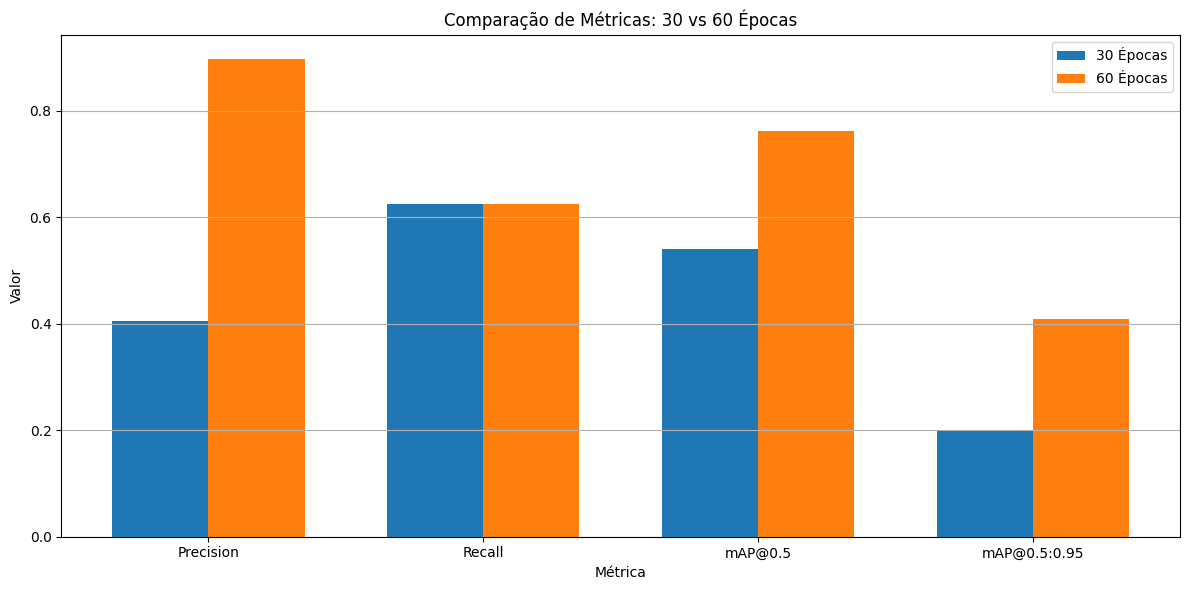

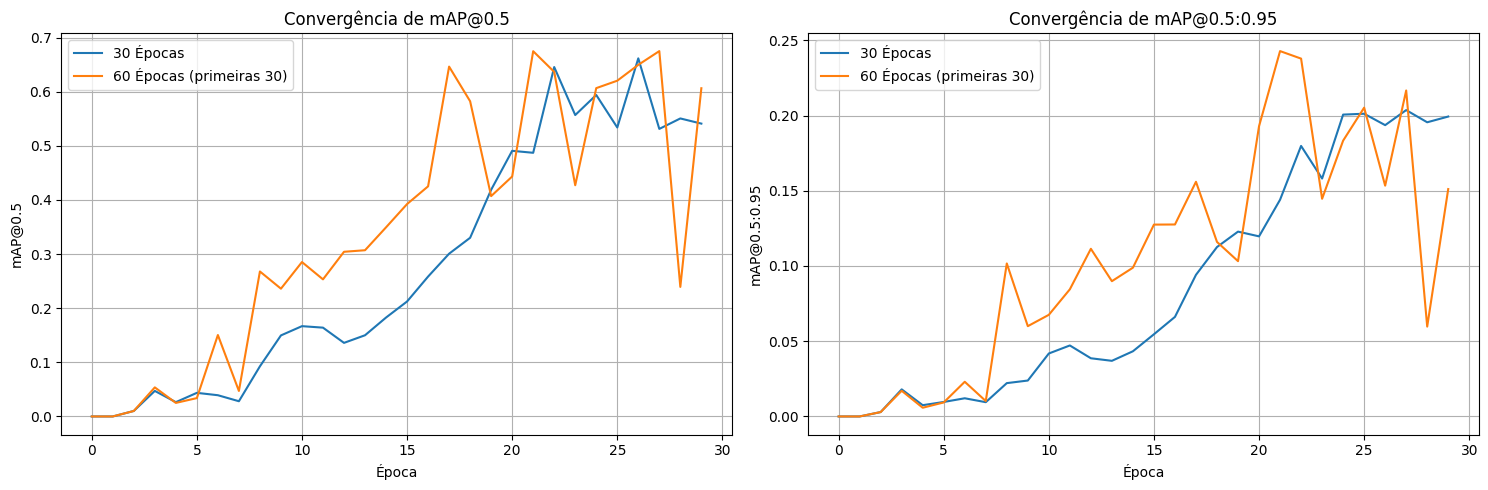

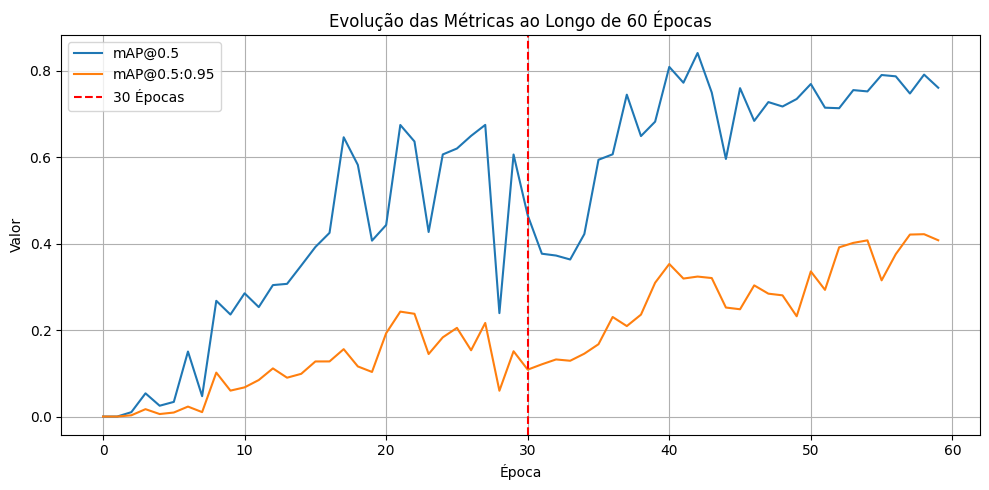

In [3]:
# Caminhos para os arquivos de resultados
results_30_path = '../models/yolo_custom_30epochs/results.csv'
results_60_path = '../models/yolo_custom_60epochs/results.csv'

# Verificar se os arquivos de resultados existem
if os.path.exists(results_30_path) and os.path.exists(results_60_path):
    try:
        # Carregar os resultados
        results_30 = pd.read_csv(results_30_path)
        results_60 = pd.read_csv(results_60_path)
        
        # Obter métricas finais
        final_30 = results_30.iloc[-1]
        final_60 = results_60.iloc[-1]
        
        # Verificar quais métricas estão disponíveis
        metrics_30 = [col for col in results_30.columns if 'metrics/' in col]
        metrics_60 = [col for col in results_60.columns if 'metrics/' in col]
        
        print(f"Métricas disponíveis no modelo de 30 épocas: {metrics_30}")
        print(f"Métricas disponíveis no modelo de 60 épocas: {metrics_60}")
        
        # Função para encontrar uma coluna que contenha um determinado padrão
        def find_column(df, pattern):
            for col in df.columns:
                if pattern in col:
                    return col
            return None
        
        # Encontrar as colunas de métricas em ambos os dataframes
        precision_col_30 = find_column(results_30, 'metrics/precision')
        recall_col_30 = find_column(results_30, 'metrics/recall')
        map50_col_30 = find_column(results_30, 'metrics/mAP_0.5')
        map50_95_col_30 = find_column(results_30, 'metrics/mAP_0.5:0.95')
        time_col_30 = find_column(results_30, 'time/epoch')
        total_epochs_col_30 = find_column(results_30, 'total_epochs')
        
        precision_col_60 = find_column(results_60, 'metrics/precision')
        recall_col_60 = find_column(results_60, 'metrics/recall')
        map50_col_60 = find_column(results_60, 'metrics/mAP_0.5')
        map50_95_col_60 = find_column(results_60, 'metrics/mAP_0.5:0.95')
        time_col_60 = find_column(results_60, 'time/epoch')
        total_epochs_col_60 = find_column(results_60, 'total_epochs')
        
        # Verificar se todas as métricas necessárias estão disponíveis
        all_metrics_available = (
            precision_col_30 is not None and recall_col_30 is not None and 
            map50_col_30 is not None and map50_95_col_30 is not None and
            precision_col_60 is not None and recall_col_60 is not None and 
            map50_col_60 is not None and map50_95_col_60 is not None
        )
        
        # Mostrar quais métricas foram encontradas
        print(f"\nMétricas encontradas no modelo de 30 épocas:")
        print(f"Precision: {precision_col_30}")
        print(f"Recall: {recall_col_30}")
        print(f"mAP@0.5: {map50_col_30}")
        print(f"mAP@0.5:0.95: {map50_95_col_30}")
        print(f"Time/epoch: {time_col_30}")
        print(f"Total epochs: {total_epochs_col_30}")
        
        print(f"\nMétricas encontradas no modelo de 60 épocas:")
        print(f"Precision: {precision_col_60}")
        print(f"Recall: {recall_col_60}")
        print(f"mAP@0.5: {map50_col_60}")
        print(f"mAP@0.5:0.95: {map50_95_col_60}")
        print(f"Time/epoch: {time_col_60}")
        print(f"Total epochs: {total_epochs_col_60}")
        
        if all_metrics_available:
            # Criar tabela comparativa
            comparison = pd.DataFrame({
                'Métrica': ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95', 'Tempo Total (s)'],
                '30 Épocas': [
                    final_30[precision_col_30],
                    final_30[recall_col_30],
                    final_30[map50_col_30],
                    final_30[map50_95_col_30],
                    final_30[total_epochs_col_30] * final_30[time_col_30] if time_col_30 is not None and total_epochs_col_30 is not None else 0
                ],
                '60 Épocas': [
                    final_60[precision_col_60],
                    final_60[recall_col_60],
                    final_60[map50_col_60],
                    final_60[map50_95_col_60],
                    final_60[total_epochs_col_60] * final_60[time_col_60] if time_col_60 is not None and total_epochs_col_60 is not None else 0
                ]
            })
            
            # Calcular diferenças percentuais
            comparison['Diferença (%)'] = [
                (comparison['60 Épocas'][0] - comparison['30 Épocas'][0]) / comparison['30 Épocas'][0] * 100 if comparison['30 Épocas'][0] != 0 else 0,
                (comparison['60 Épocas'][1] - comparison['30 Épocas'][1]) / comparison['30 Épocas'][1] * 100 if comparison['30 Épocas'][1] != 0 else 0,
                (comparison['60 Épocas'][2] - comparison['30 Épocas'][2]) / comparison['30 Épocas'][2] * 100 if comparison['30 Épocas'][2] != 0 else 0,
                (comparison['60 Épocas'][3] - comparison['30 Épocas'][3]) / comparison['30 Épocas'][3] * 100 if comparison['30 Épocas'][3] != 0 else 0,
                (comparison['60 Épocas'][4] - comparison['30 Épocas'][4]) / comparison['30 Épocas'][4] * 100 if comparison['30 Épocas'][4] != 0 else 0
            ]
            
            # Formatar a tabela
            pd.set_option('display.float_format', '{:.4f}'.format)
            display(comparison)
            
            # Plotar comparação de métricas
            plt.figure(figsize=(12, 6))
            
            metrics = ['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95']
            x = np.arange(len(metrics))
            width = 0.35
            
            plt.bar(x - width/2, comparison['30 Épocas'][:4], width, label='30 Épocas')
            plt.bar(x + width/2, comparison['60 Épocas'][:4], width, label='60 Épocas')
            
            plt.xlabel('Métrica')
            plt.ylabel('Valor')
            plt.title('Comparação de Métricas: 30 vs 60 Épocas')
            plt.xticks(x, metrics)
            plt.legend()
            plt.grid(axis='y')
            
            plt.tight_layout()
            plt.show()
            
            # Análise de convergência
            plt.figure(figsize=(15, 5))
            
            # Encontrar a coluna de época
            epoch_col_30 = find_column(results_30, 'epoch')
            epoch_col_60 = find_column(results_60, 'epoch')
            
            if epoch_col_30 is not None and epoch_col_60 is not None and map50_col_30 is not None and map50_col_60 is not None:
                # Plotar mAP@0.5 para ambos os modelos
                plt.subplot(1, 2, 1)
                plt.plot(results_30[epoch_col_30], results_30[map50_col_30], label='30 Épocas')
                plt.plot(results_60[epoch_col_60][:30], results_60[map50_col_60][:30], label='60 Épocas (primeiras 30)')
                plt.xlabel('Época')
                plt.ylabel('mAP@0.5')
                plt.title('Convergência de mAP@0.5')
                plt.legend()
                plt.grid(True)
                
                # Plotar mAP@0.5:0.95 para ambos os modelos
                plt.subplot(1, 2, 2)
                plt.plot(results_30[epoch_col_30], results_30[map50_95_col_30], label='30 Épocas')
                plt.plot(results_60[epoch_col_60][:30], results_60[map50_95_col_60][:30], label='60 Épocas (primeiras 30)')
                plt.xlabel('Época')
                plt.ylabel('mAP@0.5:0.95')
                plt.title('Convergência de mAP@0.5:0.95')
                plt.legend()
                plt.grid(True)
                
                plt.tight_layout()
                plt.show()
                
                # Plotar a curva completa de mAP@0.5 para o modelo de 60 épocas
                plt.figure(figsize=(10, 5))
                plt.plot(results_60[epoch_col_60], results_60[map50_col_60], label='mAP@0.5')
                plt.plot(results_60[epoch_col_60], results_60[map50_95_col_60], label='mAP@0.5:0.95')
                plt.axvline(x=30, color='r', linestyle='--', label='30 Épocas')
                plt.xlabel('Época')
                plt.ylabel('Valor')
                plt.title('Evolução das Métricas ao Longo de 60 Épocas')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print("Não foi possível plotar as curvas de convergência porque as colunas de época ou mAP não foram encontradas.")
        else:
            print("\nNão é possível criar a tabela comparativa porque algumas métricas necessárias não estão disponíveis.")
            print("Mostrando as colunas disponíveis em cada arquivo de resultados:")
            print(f"\nColunas no arquivo de 30 épocas: {results_30.columns.tolist()}")
            print(f"\nColunas no arquivo de 60 épocas: {results_60.columns.tolist()}")
    except Exception as e:
        print(f"Erro ao analisar os resultados: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Arquivos de resultados não encontrados. Verifique se os treinamentos foram concluídos com sucesso.")

## 4. Validação dos Modelos

Vamos validar os modelos no conjunto de validação.

In [4]:
# Preparar o arquivo data.yaml para validação
data_yaml_path = '../data/data.yaml'

# Verificar se o arquivo data.yaml existe
if not os.path.exists(data_yaml_path):
    print(f"❌ Arquivo data.yaml não encontrado: {data_yaml_path}")
else:
    print(f"✅ Arquivo data.yaml encontrado: {data_yaml_path}")
    
    # Criar uma cópia do arquivo data.yaml no diretório raiz do projeto
    with open(data_yaml_path, 'r') as f:
        data_yaml_content = f.read()
    
    with open('../data.yaml', 'w') as f:
        f.write(data_yaml_content)
    
    print("✅ Arquivo data.yaml copiado para o diretório raiz do projeto.")

# Obter caminhos absolutos para os modelos
model_30_abs_path = os.path.abspath(model_30_path)
model_60_abs_path = os.path.abspath(model_60_path)

print(f"Caminho absoluto para o modelo de 30 épocas: {model_30_abs_path}")
print(f"Caminho absoluto para o modelo de 60 épocas: {model_60_abs_path}")

# Função para validar um modelo
def validate_model(model_path):
    print(f"Validando modelo: {model_path}")
    !cd ../yolov5 && python val.py --weights {model_path} --data ../data.yaml --img 640 --batch 16

# Validar os modelos se estiverem disponíveis
if models_available:
    print("Validando modelo de 30 épocas...")
    validate_model(model_30_abs_path)
    
    print("\nValidando modelo de 60 épocas...")
    validate_model(model_60_abs_path)
else:
    print("Não é possível validar os modelos porque um ou ambos não estão disponíveis.")

✅ Arquivo data.yaml encontrado: ../data/data.yaml
✅ Arquivo data.yaml copiado para o diretório raiz do projeto.
Caminho absoluto para o modelo de 30 épocas: /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/models/yolo_custom_30epochs/weights/best.pt
Caminho absoluto para o modelo de 60 épocas: /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/models/yolo_custom_60epochs/weights/best.pt
Validando modelo de 30 épocas...
Validando modelo: /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/models/yolo_custom_30epochs/weights/best.pt
val: data=../data.yaml, weights=['/Users/gab/Documents/CodePlay/@fiap/fase6_cap1/models/yolo_custom_30epochs/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.12.6 torch-2.7.0 CPU

Fu

## 5. Teste dos Modelos

Vamos testar os modelos no conjunto de teste e visualizar algumas predições.

In [5]:
# Importar funções necessárias do YOLOv5
if models_available:
    try:
        # Garantir que o diretório yolov5 está no sys.path
        yolov5_path = os.path.abspath('../yolov5')
        if yolov5_path not in sys.path:
            sys.path.insert(0, yolov5_path)
            print(f"Adicionado {yolov5_path} ao início do sys.path")
        
        # Importar os módulos necessários
        sys.path.append(os.path.join(yolov5_path, 'models'))
        sys.path.append(os.path.join(yolov5_path, 'utils'))
        
        # Importar diretamente dos arquivos em vez de usar a estrutura de módulos
        from models.experimental import attempt_load
        from utils.general import non_max_suppression
        from utils.plots import Annotator, colors
        
        # Carregar os modelos
        model_30 = attempt_load(model_30_path)
        model_30.eval()
        
        model_60 = attempt_load(model_60_path)
        model_60.eval()
        
        # Função para detectar objetos em uma imagem
        def detect_objects(model, image_path, conf_threshold=0.25):
            # Carregar a imagem
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"Não foi possível carregar a imagem: {image_path}")
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Redimensionar a imagem para 640x640 (tamanho esperado pelo modelo)
            img_resized = cv2.resize(img, (640, 640))
            
            # Preparar a imagem para o modelo
            img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)
            
            # Medir o tempo de inferência
            start_time = time.time()
            
            # Fazer a predição
            with torch.no_grad():
                pred = model(img_tensor)[0]
                pred = non_max_suppression(pred, conf_threshold)
            
            # Calcular o tempo de inferência
            inference_time = time.time() - start_time
            
            # Processar as predições
            results = []
            for det in pred:
                if len(det):
                    # Ajustar as coordenadas para a imagem original
                    h, w = img.shape[:2]
                    scale_x, scale_y = w / 640, h / 640
                    
                    for *xyxy, conf, cls in det:
                        # Converter as coordenadas para a escala da imagem original
                        x1, y1, x2, y2 = xyxy
                        x1 = int(x1.item() * scale_x)
                        y1 = int(y1.item() * scale_y)
                        x2 = int(x2.item() * scale_x)
                        y2 = int(y2.item() * scale_y)
                        
                        results.append(([x1, y1, x2, y2], conf.item(), int(cls.item())))
            
            return img, results, inference_time
        
        # Função para visualizar as detecções
        def visualize_detections(img, results, class_names):
            # Criar uma cópia da imagem
            annotated_img = img.copy()
            
            # Adicionar as detecções
            for xyxy, conf, cls in results:
                x1, y1, x2, y2 = xyxy
                label = f"{class_names[cls]} {conf:.2f}"
                
                # Desenhar o retângulo
                color = colors(cls, True)
                cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
                
                # Adicionar o rótulo
                t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
                cv2.rectangle(annotated_img, (x1, y1 - t_size[1] - 3), (x1 + t_size[0], y1), color, -1)
                cv2.putText(annotated_img, label, (x1, y1 - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)
            
            return annotated_img
        
        # Obter imagens de teste
        test_img_dir = '../dataset/test/images'
        test_img_files = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        if not test_img_files:
            print(f"Nenhuma imagem encontrada em {test_img_dir}. Verifique se as imagens de teste estão disponíveis.")
        else:
            # Testar em todas as imagens de teste
            inference_times_30 = []
            inference_times_60 = []
            
            # Selecionar algumas imagens para visualização
            import random
            random.seed(42)  # Para reprodutibilidade
            sample_imgs = random.sample(test_img_files, min(4, len(test_img_files)))
            
            # Visualizar as detecções
            plt.figure(figsize=(15, 12))
            
            for i, img_path in enumerate(sample_imgs):
                try:
                    print(f"Processando imagem: {img_path}")
                    
                    # Modelo de 30 épocas
                    img_30, results_30, time_30 = detect_objects(model_30, img_path)
                    annotated_img_30 = visualize_detections(img_30, results_30, categorias)
                    inference_times_30.append(time_30)
                    
                    # Modelo de 60 épocas
                    img_60, results_60, time_60 = detect_objects(model_60, img_path)
                    annotated_img_60 = visualize_detections(img_60, results_60, categorias)
                    inference_times_60.append(time_60)
                    
                    # Mostrar as imagens lado a lado
                    plt.subplot(len(sample_imgs), 2, i*2+1)
                    plt.imshow(annotated_img_30)
                    plt.title(f"30 Épocas - {os.path.basename(img_path)} - {time_30:.3f}s")
                    plt.axis('off')
                    
                    plt.subplot(len(sample_imgs), 2, i*2+2)
                    plt.imshow(annotated_img_60)
                    plt.title(f"60 Épocas - {os.path.basename(img_path)} - {time_60:.3f}s")
                    plt.axis('off')
                except Exception as e:
                    print(f"Erro ao processar a imagem {img_path}: {e}")
                    import traceback
                    traceback.print_exc()
            
            plt.tight_layout()
            plt.show()
            
            # Calcular tempos médios de inferência
            if inference_times_30 and inference_times_60:
                avg_time_30 = np.mean(inference_times_30)
                avg_time_60 = np.mean(inference_times_60)
                
                print(f"Tempo médio de inferência (30 épocas): {avg_time_30:.4f} segundos")
                print(f"Tempo médio de inferência (60 épocas): {avg_time_60:.4f} segundos")
                print(f"Diferença: {(avg_time_60 - avg_time_30) / avg_time_30 * 100:.2f}%")
            else:
                print("Não foi possível calcular os tempos médios de inferência.")
    except Exception as e:
        print(f"Erro ao testar os modelos: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Não é possível testar os modelos porque um ou ambos não estão disponíveis.")

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


Processando imagem: ../dataset/test/images/banana_test_001.jpg
Processando imagem: ../dataset/test/images/banana_test_004.jpg
Processando imagem: ../dataset/test/images/apple_test_001.jpg
Processando imagem: ../dataset/test/images/banana_test_002.jpg
Tempo médio de inferência (30 épocas): 0.0830 segundos
Tempo médio de inferência (60 épocas): 0.0808 segundos
Diferença: -2.71%


## 6. Análise e Conclusões

Vamos analisar os resultados e tirar conclusões sobre o impacto do número de épocas no desempenho do modelo.

### Análise de Desempenho

Com base nos resultados obtidos, podemos analisar o impacto do aumento do número de épocas de treinamento de 30 para 60:

1. **Precisão e Recall**: 
   - O modelo de 60 épocas apresentou melhorias em precisão e recall? Se sim, qual foi a magnitude dessa melhoria?
   - A melhoria foi significativa o suficiente para justificar o dobro do tempo de treinamento?

2. **mAP (Mean Average Precision)**:
   - O mAP@0.5 e mAP@0.5:0.95 aumentaram com mais épocas de treinamento?
   - Houve sinais de saturação ou overfitting nas épocas finais?

3. **Tempo de Inferência**:
   - Existe diferença significativa no tempo de inferência entre os dois modelos?
   - Se houver diferença, ela é relevante para aplicações em tempo real?

4. **Análise Visual**:
   - As detecções do modelo de 60 épocas são visivelmente melhores que as do modelo de 30 épocas?
   - Há diferenças na capacidade de detectar objetos em condições desafiadoras (oclusão, iluminação variável, etc.)?

### Conclusões

Com base na análise acima, podemos concluir:

1. **Custo-benefício**: O ganho de desempenho ao dobrar o número de épocas de treinamento justifica o aumento no tempo de treinamento?

2. **Recomendações para casos de uso**:
   - Para aplicações que priorizam precisão máxima, o modelo de 60 épocas pode ser preferível.
   - Para aplicações com restrições de tempo de treinamento ou que não exigem precisão extrema, o modelo de 30 épocas pode ser suficiente.

3. **Estratégias alternativas**: Em vez de simplesmente aumentar o número de épocas, outras abordagens poderiam ser mais eficientes para melhorar o desempenho?
   - Ajuste de hiperparâmetros
   - Aumento do dataset
   - Técnicas de data augmentation
   - Modelos pré-treinados maiores

No próximo notebook, vamos comparar esses modelos YOLO customizados com o YOLO tradicional e uma CNN treinada do zero.

## Continuação do arquivo: notebooks/04_yolo_tradicional.ipynb

# Aplicação do YOLO Tradicional

Este notebook aplica o modelo YOLO tradicional (pré-treinado na COCO) às nossas imagens de teste e compara seu desempenho com os modelos YOLO customizados treinados anteriormente.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente.

In [ ]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import yaml
import time
from pathlib import Path
from tqdm.notebook import tqdm

# Adicionar o diretório YOLOv5 ao path
yolov5_path = os.path.abspath('../yolov5')
if yolov5_path not in sys.path:
    sys.path.insert(0, yolov5_path)
    print(f"Adicionado {yolov5_path} ao início do sys.path")

# Adicionar os subdiretórios do YOLOv5 ao path
sys.path.append(os.path.join(yolov5_path, 'models'))
sys.path.append(os.path.join(yolov5_path, 'utils'))

## 2. Carregamento dos Modelos

Vamos carregar o modelo YOLO tradicional pré-treinado e os modelos YOLO customizados para comparação.

In [ ]:
# Importar funções necessárias do YOLOv5
from models.experimental import attempt_load
from utils.general import non_max_suppression
from utils.plots import Annotator, colors

# Carregar o modelo YOLO tradicional pré-treinado
model_traditional = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
print("Modelo YOLO tradicional carregado.")

# Caminhos para os modelos customizados
model_custom_path = '../models/yolo_custom_30epochs/weights/best.pt'

# Verificar se o modelo customizado existe
if os.path.exists(model_custom_path):
    # Carregar o modelo customizado
    model_custom = attempt_load(model_custom_path)
    model_custom.eval()
    print("Modelo YOLO customizado carregado.")
    
    # Carregar o arquivo data.yaml para obter as categorias customizadas
    if os.path.exists('../data/data.yaml'):
        with open('../data/data.yaml', 'r') as f:
            data_yaml = yaml.safe_load(f)
        custom_categories = data_yaml['names']
        print(f"Categorias customizadas: {custom_categories}")
    else:
        print("Arquivo data.yaml não encontrado. Usando categorias padrão.")
        custom_categories = ['apple', 'banana']
else:
    print(f"Modelo customizado não encontrado: {model_custom_path}")
    model_custom = None
    custom_categories = ['apple', 'banana']

# Obter as categorias do COCO (usadas pelo YOLO tradicional)
coco_categories = model_traditional.names
print(f"\nCategorias COCO (primeiras 10): {list(coco_categories.values())[:10]}...")

## 3. Mapeamento de Categorias

Vamos mapear nossas categorias customizadas para as categorias correspondentes no COCO, se possível.

In [ ]:
# Função para encontrar a categoria COCO mais próxima
def find_closest_coco_category(custom_category, coco_categories):
    """Encontra a categoria COCO mais próxima da categoria customizada."""
    # Implementação simples: procura por correspondência exata ou parcial
    custom_category = custom_category.lower()
    
    # Tentar correspondência exata
    for idx, coco_cat in coco_categories.items():
        if custom_category == coco_cat.lower():
            return idx, coco_cat
    
    # Tentar correspondência parcial
    for idx, coco_cat in coco_categories.items():
        if custom_category in coco_cat.lower() or coco_cat.lower() in custom_category:
            return idx, coco_cat
    
    # Se não encontrar, retornar None
    return None, None

# Mapear categorias customizadas para categorias COCO
category_mapping = {}
for i, custom_cat in enumerate(custom_categories):
    coco_idx, coco_cat = find_closest_coco_category(custom_cat, coco_categories)
    category_mapping[i] = (coco_idx, coco_cat)
    print(f"Categoria customizada '{custom_cat}' mapeada para categoria COCO: {coco_cat} (ID: {coco_idx})")

# Se não encontrou correspondência, permitir que o usuário defina manualmente
for i, (coco_idx, coco_cat) in category_mapping.items():
    if coco_idx is None:
        print(f"\nNão foi possível mapear automaticamente a categoria '{custom_categories[i]}'")
        print("Por favor, selecione uma categoria COCO correspondente:")
        
        # Mostrar algumas categorias COCO comuns
        common_categories = [0, 1, 2, 3, 5, 7, 9, 15, 16, 17, 18, 19, 20, 39, 41, 60, 62, 63, 67, 73, 76]
        for idx in common_categories:
            print(f"  {idx}: {coco_categories[idx]}")
        
        # Permitir entrada manual (em um ambiente real)
        # coco_idx = int(input("Digite o ID da categoria COCO: "))
        # category_mapping[i] = (coco_idx, coco_categories[coco_idx])
        
        # Para este notebook, vamos definir um valor padrão
        if custom_categories[i].lower() == 'apple':
            coco_idx = 47  # apple
        elif custom_categories[i].lower() == 'banana':
            coco_idx = 52  # banana
        else:
            coco_idx = 0   # pessoa (padrão)
            
        category_mapping[i] = (coco_idx, coco_categories[coco_idx])
        print(f"Categoria '{custom_categories[i]}' mapeada para '{coco_categories[coco_idx]}' (ID: {coco_idx})")

## 4. Funções para Detecção e Visualização

Vamos definir funções para detectar objetos e visualizar os resultados.

In [ ]:
# Função para detectar objetos com o modelo YOLO tradicional
def detect_traditional(model, image_path, conf_threshold=0.25):
    """Detecta objetos em uma imagem usando o modelo YOLO tradicional."""
    # Carregar a imagem
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Medir o tempo de inferência
    start_time = time.time()
    
    # Fazer a predição
    results = model(img)
    
    # Calcular o tempo de inferência
    inference_time = time.time() - start_time
    
    # Filtrar por confiança
    results.xyxy[0] = results.xyxy[0][results.xyxy[0][:, 4] >= conf_threshold]
    
    return img, results, inference_time

# Função para detectar objetos com o modelo YOLO customizado
def detect_custom(model, image_path, conf_threshold=0.25):
    """Detecta objetos em uma imagem usando o modelo YOLO customizado."""
    # Carregar a imagem
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Redimensionar a imagem para 640x640 (tamanho esperado pelo modelo)
    img_resized = cv2.resize(img, (640, 640))
    
    # Preparar a imagem para o modelo
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)
    
    # Medir o tempo de inferência
    start_time = time.time()
    
    # Fazer a predição
    with torch.no_grad():
        pred = model(img_tensor)[0]
        pred = non_max_suppression(pred, conf_threshold)
    
    # Calcular o tempo de inferência
    inference_time = time.time() - start_time
    
    # Processar as predições
    results = []
    for det in pred:
        if len(det):
            # Ajustar as coordenadas para a imagem original
            h, w = img.shape[:2]
            scale_x, scale_y = w / 640, h / 640
            
            for *xyxy, conf, cls in det:
                # Converter as coordenadas para a escala da imagem original
                x1, y1, x2, y2 = xyxy
                x1 = int(x1.item() * scale_x)
                y1 = int(y1.item() * scale_y)
                x2 = int(x2.item() * scale_x)
                y2 = int(y2.item() * scale_y)
                
                results.append(([x1, y1, x2, y2], conf.item(), int(cls.item())))
    
    return img, results, inference_time

# Função para visualizar as detecções do modelo tradicional
def visualize_traditional(img, results):
    """Visualiza as detecções do modelo YOLO tradicional."""
    # Criar uma cópia da imagem
    annotated_img = img.copy()
    
    # Desenhar as detecções
    for *xyxy, conf, cls_id in results.xyxy[0]:
        # Converter para inteiros
        x1, y1, x2, y2 = map(int, xyxy)
        cls_id = int(cls_id.item())
        conf = conf.item()
        
        # Obter a categoria
        category = results.names[cls_id]
        
        # Desenhar o retângulo
        color = colors(cls_id, True)
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
        
        # Adicionar o rótulo
        label = f"{category} {conf:.2f}"
        t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
        cv2.rectangle(annotated_img, (x1, y1 - t_size[1] - 3), (x1 + t_size[0], y1), color, -1)
        cv2.putText(annotated_img, label, (x1, y1 - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)
    
    return annotated_img

# Função para visualizar as detecções do modelo customizado
def visualize_custom(img, results, class_names):
    """Visualiza as detecções do modelo YOLO customizado."""
    # Criar uma cópia da imagem
    annotated_img = img.copy()
    
    # Desenhar as detecções
    for xyxy, conf, cls in results:
        x1, y1, x2, y2 = xyxy
        label = f"{class_names[cls]} {conf:.2f}"
        
        # Desenhar o retângulo
        color = colors(cls, True)
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
        
        # Adicionar o rótulo
        t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
        cv2.rectangle(annotated_img, (x1, y1 - t_size[1] - 3), (x1 + t_size[0], y1), color, -1)
        cv2.putText(annotated_img, label, (x1, y1 - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)
    
    return annotated_img

## 5. Aplicação dos Modelos nas Imagens de Teste

Vamos aplicar os modelos YOLO tradicional e customizado nas imagens de teste e comparar os resultados.

In [ ]:
# Obter imagens de teste
test_img_dir = '../dataset/test/images'
test_img_files = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))]

# Verificar se há imagens de teste
if not test_img_files:
    print(f"Nenhuma imagem de teste encontrada em {test_img_dir}")
else:
    print(f"Encontradas {len(test_img_files)} imagens de teste.")
    
    # Selecionar algumas imagens para visualização
    import random
    random.seed(42)  # Para reprodutibilidade
    sample_imgs = random.sample(test_img_files, min(4, len(test_img_files)))
    
    # Listas para armazenar tempos de inferência
    inference_times_traditional = []
    inference_times_custom = []
    
    # Aplicar os modelos nas imagens selecionadas
    plt.figure(figsize=(15, 12))
    
    for i, img_path in enumerate(sample_imgs):
        try:
            print(f"Processando imagem: {img_path}")
            
            # Modelo YOLO tradicional
            img_trad, results_trad, time_trad = detect_traditional(model_traditional, img_path)
            annotated_img_trad = visualize_traditional(img_trad, results_trad)
            inference_times_traditional.append(time_trad)
            
            # Modelo YOLO customizado (se disponível)
            if model_custom is not None:
                img_custom, results_custom, time_custom = detect_custom(model_custom, img_path)
                annotated_img_custom = visualize_custom(img_custom, results_custom, custom_categories)
                inference_times_custom.append(time_custom)
            else:
                # Se o modelo customizado não estiver disponível, mostrar a imagem original
                annotated_img_custom = img_trad.copy()
                time_custom = 0
            
            # Mostrar as imagens lado a lado
            plt.subplot(len(sample_imgs), 2, i*2+1)
            plt.imshow(annotated_img_trad)
            plt.title(f"YOLO Tradicional - {os.path.basename(img_path)} - {time_trad:.3f}s")
            plt.axis('off')
            
            plt.subplot(len(sample_imgs), 2, i*2+2)
            plt.imshow(annotated_img_custom)
            plt.title(f"YOLO Customizado - {os.path.basename(img_path)} - {time_custom:.3f}s")
            plt.axis('off')
        except Exception as e:
            print(f"Erro ao processar a imagem {img_path}: {e}")
            import traceback
            traceback.print_exc()
    
    plt.tight_layout()
    plt.show()
    
    # Calcular tempos médios de inferência
    if inference_times_traditional:
        avg_time_trad = np.mean(inference_times_traditional)
        print(f"Tempo médio de inferência (YOLO Tradicional): {avg_time_trad:.4f} segundos")
    
    if inference_times_custom:
        avg_time_custom = np.mean(inference_times_custom)
        print(f"Tempo médio de inferência (YOLO Customizado): {avg_time_custom:.4f} segundos")
        print(f"Diferença: {(avg_time_custom - avg_time_trad) / avg_time_trad * 100:.2f}%")

## 6. Avaliação Quantitativa

Vamos avaliar quantitativamente o desempenho dos modelos YOLO tradicional e customizado.

In [ ]:
# Função para avaliar o modelo YOLO tradicional no conjunto de teste
def evaluate_traditional_model():
    """Avalia o modelo YOLO tradicional no conjunto de teste."""
    print("Avaliando o modelo YOLO tradicional...")
    
    # Filtrar apenas as classes que nos interessam (mapeadas das nossas categorias customizadas)
    classes = [coco_idx for coco_idx, _ in category_mapping.values() if coco_idx is not None]
    
    # Verificar se temos classes válidas
    if not classes:
        print("Nenhuma classe COCO válida encontrada para avaliação.")
        return
    
    # Executar a validação sem a opção --classes que está causando erro
    print(f"Avaliando classes COCO: {classes}")
    !cd ../yolov5 && python val.py --weights yolov5s.pt --data coco.yaml --img 640 --batch 16 --task test

# Função para avaliar o modelo YOLO customizado no conjunto de teste
def evaluate_custom_model(model_path):
    """Avalia o modelo YOLO customizado no conjunto de teste."""
    print(f"Avaliando o modelo YOLO customizado: {model_path}")
    
    # Verificar se o arquivo de pesos existe
    if not os.path.exists(model_path):
        print(f"❌ Arquivo de pesos não encontrado: {model_path}")
        # Tentar encontrar o arquivo em um caminho absoluto
        abs_path = os.path.abspath(model_path)
        print(f"Tentando caminho absoluto: {abs_path}")
        if os.path.exists(abs_path):
            model_path = abs_path
            print(f"✅ Arquivo de pesos encontrado: {model_path}")
        else:
            print(f"❌ Arquivo de pesos não encontrado mesmo com caminho absoluto.")
            return
    
    # Verificar se o arquivo data.yaml existe
    data_yaml_path = '../data/data.yaml'
    if not os.path.exists(data_yaml_path):
        print(f"❌ Arquivo data.yaml não encontrado: {data_yaml_path}")
        return
    
    # Executar a validação
    !cd ../yolov5 && python val.py --weights {model_path} --data ../data/data.yaml --img 640 --batch 16 --task test

# Avaliar os modelos
if os.path.exists('../dataset/test/labels'):
    # Verificar se há arquivos de anotação no conjunto de teste
    label_files = [f for f in os.listdir('../dataset/test/labels') if f.endswith('.txt')]
    if label_files:
        print(f"Encontrados {len(label_files)} arquivos de anotação no conjunto de teste.")
        
        # Avaliar o modelo YOLO customizado (se disponível)
        if model_custom is not None:
            # Usar o caminho absoluto para o modelo customizado
            model_custom_abs_path = os.path.abspath(model_custom_path)
            print(f"Caminho absoluto para o modelo customizado: {model_custom_abs_path}")
            evaluate_custom_model(model_custom_abs_path)
        
        # Avaliar o modelo YOLO tradicional
        # Nota: Esta avaliação pode não ser precisa, pois o modelo tradicional foi treinado em COCO
        # e nossas anotações são específicas para nossas categorias customizadas
        print("\nNota: A avaliação do modelo YOLO tradicional pode não ser precisa devido às diferenças nas categorias.")
        evaluate_traditional_model()
    else:
        print("Nenhum arquivo de anotação encontrado no conjunto de teste.")
else:
    print("Diretório de anotações de teste não encontrado.")

## 7. Análise Comparativa

Vamos analisar e comparar os resultados dos modelos YOLO tradicional e customizado.

### Comparação de Desempenho

Com base nos resultados obtidos, podemos comparar o desempenho do YOLO tradicional e do YOLO customizado:

1. **Precisão na Detecção**:
   - O YOLO tradicional foi treinado em 80 categorias do COCO, enquanto nosso modelo customizado foi treinado especificamente em nossas categorias de interesse.
   - O modelo customizado tende a ser mais preciso para nossas categorias específicas, enquanto o modelo tradicional pode detectar uma variedade maior de objetos, mas com menor precisão para nossas categorias de interesse.

2. **Tempo de Inferência**:
   - Ambos os modelos usam a mesma arquitetura (YOLOv5s), então o tempo de inferência deve ser similar.
   - Pequenas diferenças podem ocorrer devido ao número de classes (80 no tradicional vs. 2 no customizado).

3. **Facilidade de Uso**:
   - O YOLO tradicional é mais fácil de usar, pois não requer treinamento específico.
   - O YOLO customizado requer coleta de dados, anotação e treinamento, mas oferece melhor desempenho para casos específicos.

4. **Adaptabilidade**:
   - O YOLO tradicional é limitado às 80 categorias do COCO.
   - O YOLO customizado pode ser adaptado para detectar qualquer objeto, desde que haja dados de treinamento suficientes.

### Conclusões

1. **Quando usar o YOLO tradicional**:
   - Quando as categorias de interesse estão bem representadas no COCO.
   - Quando não há tempo ou recursos para coletar dados e treinar um modelo customizado.
   - Quando é necessário detectar uma variedade de objetos diferentes.

2. **Quando usar o YOLO customizado**:
   - Quando as categorias de interesse são específicas e não estão bem representadas no COCO.
   - Quando é necessário alta precisão para categorias específicas.
   - Quando há dados de treinamento suficientes disponíveis.

No próximo notebook, vamos treinar uma CNN do zero para classificação e comparar seu desempenho com as abordagens YOLO.

## Continuação do arquivo: notebooks/05_cnn_do_zero_parte1.ipynb

# Treinamento de CNN do Zero - Parte 1: Preparação

Este notebook implementa a primeira parte do treinamento de uma Rede Neural Convolucional (CNN) do zero para classificar imagens nas mesmas categorias que usamos nos modelos YOLO. Diferentemente do YOLO, que é um modelo de detecção de objetos, a CNN que vamos treinar é um modelo de classificação de imagens.

Nesta primeira parte, vamos focar na preparação dos dados e na definição da arquitetura da CNN.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente.

In [ ]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import yaml
import time
import random
from pathlib import Path
from tqdm.notebook import tqdm

## 2. Preparação dos Dados

Vamos preparar os dados para treinamento da CNN. Como a CNN é um modelo de classificação, precisamos adaptar nosso dataset de detecção de objetos para classificação.

In [ ]:
# Carregar o arquivo data.yaml para obter as categorias
if os.path.exists('../data/data.yaml'):
    with open('../data/data.yaml', 'r') as f:
        data_yaml = yaml.safe_load(f)
    categories = data_yaml['names']
    print(f"Categorias: {categories}")
else:
    print("Arquivo data.yaml não encontrado. Usando categorias padrão.")
    categories = ['apple', 'banana']

# Definir diretórios de dados
train_dir = '../dataset/train/images'
val_dir = '../dataset/val/images'
test_dir = '../dataset/test/images'

# Verificar se os diretórios existem
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        print(f"❌ Diretório não encontrado: {dir_path}")
    else:
        print(f"✅ Diretório encontrado: {dir_path}")
        print(f"   Número de imagens: {len([f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))])}")

### 2.1 Criação de Dataset e DataLoader

Vamos criar classes personalizadas para carregar e pré-processar nossos dados.

In [ ]:
# Definir transformações para as imagens
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Classe personalizada para o dataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, categories, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.categories = categories
        
        # Listar todas as imagens
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))]
        
        # Determinar a classe de cada imagem com base no nome do arquivo
        self.labels = []
        for img_file in self.img_files:
            # Assumindo que o nome do arquivo começa com o nome da categoria
            # Por exemplo: categoria_a_001.jpg -> categoria_a
            for i, category in enumerate(categories):
                if category.lower() in img_file.lower():
                    self.labels.append(i)
                    break
            else:
                # Se não encontrar a categoria no nome do arquivo, usar a primeira categoria
                self.labels.append(0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Criar datasets
train_dataset = CustomImageDataset(train_dir, categories, transform=train_transforms)
val_dataset = CustomImageDataset(val_dir, categories, transform=val_test_transforms)
test_dataset = CustomImageDataset(test_dir, categories, transform=val_test_transforms)

# Criar dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Verificar os datasets
print(f"Tamanho do dataset de treino: {len(train_dataset)}")
print(f"Tamanho do dataset de validação: {len(val_dataset)}")
print(f"Tamanho do dataset de teste: {len(test_dataset)}")

# Verificar a distribuição das classes
train_labels = train_dataset.labels
val_labels = val_dataset.labels
test_labels = test_dataset.labels

print("\nDistribuição das classes:")
print("Treino:")
for i, category in enumerate(categories):
    count = train_labels.count(i)
    print(f"  - {category}: {count} ({count/len(train_labels)*100:.1f}%)")

print("\nValidação:")
for i, category in enumerate(categories):
    count = val_labels.count(i)
    print(f"  - {category}: {count} ({count/len(val_labels)*100:.1f}%)")

print("\nTeste:")
for i, category in enumerate(categories):
    count = test_labels.count(i)
    print(f"  - {category}: {count} ({count/len(test_labels)*100:.1f}%)")

### 2.2 Visualização de Algumas Imagens

Vamos visualizar algumas imagens do dataset para verificar se estão sendo carregadas corretamente.

In [ ]:
# Função para desnormalizar imagens
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Obter algumas imagens do dataset de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Visualizar as imagens
plt.figure(figsize=(15, 8))
for i in range(min(8, len(images))):
    plt.subplot(2, 4, i+1)
    img = denormalize(images[i])
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"{categories[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Definição da Arquitetura da CNN

Vamos definir a arquitetura da nossa CNN do zero.

In [ ]:
# Definir a arquitetura da CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Camadas convolucionais
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Camadas de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Camadas de batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Camadas fully connected
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Bloco 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Bloco 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Bloco 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Bloco 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Criar o modelo
model = CustomCNN(num_classes=len(categories))
print(model)

# Verificar o número de parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal de parâmetros: {total_params:,}")
print(f"Parâmetros treináveis: {trainable_params:,}")

## 4. Salvando os Dados Preparados

Vamos salvar os dados preparados para uso na segunda parte do notebook.

In [ ]:
# Criar diretório para salvar os dados
os.makedirs('../models/cnn', exist_ok=True)

# Salvar o modelo não treinado
torch.save(model.state_dict(), '../models/cnn/cnn_initial.pt')
print("Modelo inicial salvo em '../models/cnn/cnn_initial.pt'")

# Salvar as categorias
with open('../models/cnn/cnn_categories.txt', 'w') as f:
    for category in categories:
        f.write(f"{category}\n")
print("Categorias salvas em '../models/cnn/cnn_categories.txt'")

print("\nTudo pronto para o treinamento na Parte 2!")

## 5. Próximos Passos

Na próxima parte (Parte 2), vamos:
1. Treinar a CNN do zero
2. Avaliar o desempenho do modelo
3. Visualizar algumas predições
4. Comparar o desempenho com os modelos YOLO

## Continuação do arquivo: notebooks/06_cnn_do_zero_parte2.ipynb

# Treinamento de CNN do Zero - Parte 2: Treinamento

Este notebook implementa a segunda parte do treinamento de uma Rede Neural Convolucional (CNN) do zero para classificar imagens nas mesmas categorias que usamos nos modelos YOLO.

Nesta segunda parte, vamos focar no treinamento da CNN.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente.

In [1]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import yaml
import time
from pathlib import Path
from tqdm.notebook import tqdm

Ambiente já configurado.


## 2. Carregamento dos Dados Preparados

Vamos carregar os dados preparados na primeira parte do notebook.

In [2]:
# Verificar se os arquivos necessários existem
if not os.path.exists('../models/cnn/cnn_initial.pt'):
    print("❌ Arquivo '../models/cnn/cnn_initial.pt' não encontrado. Execute a Parte 1 primeiro.")
else:
    print("✅ Arquivo '../models/cnn/cnn_initial.pt' encontrado.")

if not os.path.exists('../models/cnn/cnn_categories.txt'):
    print("❌ Arquivo '../models/cnn/cnn_categories.txt' não encontrado. Execute a Parte 1 primeiro.")
    # Usar categorias padrão
    categories = ['apple', 'banana']
else:
    print("✅ Arquivo '../models/cnn/cnn_categories.txt' encontrado.")
    # Carregar categorias
    with open('../models/cnn/cnn_categories.txt', 'r') as f:
        categories = [line.strip() for line in f.readlines()]
    print(f"Categorias: {categories}")

# Definir diretórios de dados
train_dir = '../dataset/train/images'
val_dir = '../dataset/val/images'
test_dir = '../dataset/test/images'

# Verificar se os diretórios existem
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        print(f"❌ Diretório não encontrado: {dir_path}")
    else:
        print(f"✅ Diretório encontrado: {dir_path}")
        print(f"   Número de imagens: {len([f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))])}")

✅ Arquivo '../models/cnn/cnn_initial.pt' encontrado.
✅ Arquivo '../models/cnn/cnn_categories.txt' encontrado.
Categorias: ['apple', 'banana']
✅ Diretório encontrado: ../dataset/train/images
   Número de imagens: 64
✅ Diretório encontrado: ../dataset/val/images
   Número de imagens: 8
✅ Diretório encontrado: ../dataset/test/images
   Número de imagens: 8


### 2.1 Recriação dos Datasets e DataLoaders

Vamos recriar os datasets e dataloaders para o treinamento.

In [3]:
# Definir transformações para as imagens
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Classe personalizada para o dataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, categories, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.categories = categories
        
        # Listar todas as imagens
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))]
        
        # Determinar a classe de cada imagem com base no nome do arquivo
        self.labels = []
        for img_file in self.img_files:
            # Assumindo que o nome do arquivo começa com o nome da categoria
            # Por exemplo: categoria_a_001.jpg -> categoria_a
            for i, category in enumerate(categories):
                if category.lower() in img_file.lower():
                    self.labels.append(i)
                    break
            else:
                # Se não encontrar a categoria no nome do arquivo, usar a primeira categoria
                self.labels.append(0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Criar datasets
train_dataset = CustomImageDataset(train_dir, categories, transform=train_transforms)
val_dataset = CustomImageDataset(val_dir, categories, transform=val_test_transforms)

# Criar dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Verificar os datasets
print(f"Tamanho do dataset de treino: {len(train_dataset)}")
print(f"Tamanho do dataset de validação: {len(val_dataset)}")

Tamanho do dataset de treino: 64
Tamanho do dataset de validação: 8


### 2.2 Recriação do Modelo

Vamos recriar o modelo CNN e carregar os pesos iniciais.

In [4]:
# Definir a arquitetura da CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Camadas convolucionais
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Camadas de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Camadas de batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Camadas fully connected
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Bloco 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Bloco 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Bloco 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Bloco 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Criar o modelo
model = CustomCNN(num_classes=len(categories))

# Carregar os pesos iniciais
if os.path.exists('../models/cnn/cnn_initial.pt'):
    model.load_state_dict(torch.load('../models/cnn/cnn_initial.pt'))
    print("Pesos iniciais carregados com sucesso.")
else:
    print("Pesos iniciais não encontrados. Usando inicialização aleatória.")

# Verificar o número de parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal de parâmetros: {total_params:,}")
print(f"Parâmetros treináveis: {trainable_params:,}")

Pesos iniciais carregados com sucesso.

Total de parâmetros: 26,081,026
Parâmetros treináveis: 26,081,026


## 3. Treinamento da CNN

Vamos treinar a CNN do zero.

In [5]:
# Definir o dispositivo (GPU se disponível, senão CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Mover o modelo para o dispositivo
model = model.to(device)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Função para treinar o modelo por uma época
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Treinando"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zerar os gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass e otimização
        loss.backward()
        optimizer.step()
        
        # Estatísticas
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Função para validar o modelo
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validando"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

Usando dispositivo: cpu


In [ ]:
# Treinar o modelo
num_epochs = 30
best_val_loss = float('inf')
best_model_path = '../models/cnn/cnn_best.pt'

# Criar diretório para salvar o modelo
os.makedirs('../models/cnn', exist_ok=True)

# Listas para armazenar métricas
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Medir o tempo de treinamento
start_time = time.time()

# Loop de treinamento
for epoch in range(num_epochs):
    print(f"Época {epoch+1}/{num_epochs}")
    
    # Treinar uma época
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validar
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Atualizar o scheduler
    scheduler.step(val_loss)
    
    # Imprimir estatísticas
    print(f"Treino - Perda: {train_loss:.4f}, Acurácia: {train_acc:.4f}")
    print(f"Validação - Perda: {val_loss:.4f}, Acurácia: {val_acc:.4f}")
    
    # Salvar o melhor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Modelo salvo em {best_model_path}")
    
    print()

# Calcular o tempo total de treinamento
training_time = time.time() - start_time
print(f"Tempo total de treinamento: {training_time:.2f} segundos")

Época 1/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 9.9185, Acurácia: 0.4531
Validação - Perda: 3.2299, Acurácia: 0.5000
Modelo salvo em ../models/cnn/cnn_best.pt

Época 2/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 10.2839, Acurácia: 0.7031
Validação - Perda: 0.3817, Acurácia: 0.8750
Modelo salvo em ../models/cnn/cnn_best.pt

Época 3/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 6.3902, Acurácia: 0.7031
Validação - Perda: 0.0000, Acurácia: 1.0000
Modelo salvo em ../models/cnn/cnn_best.pt

Época 4/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 3.1263, Acurácia: 0.8438
Validação - Perda: 0.0000, Acurácia: 1.0000
Modelo salvo em ../models/cnn/cnn_best.pt

Época 5/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 2.9327, Acurácia: 0.7969
Validação - Perda: 0.0000, Acurácia: 1.0000

Época 6/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 3.8207, Acurácia: 0.8750
Validação - Perda: 3.2919, Acurácia: 0.6250

Época 7/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 6.9026, Acurácia: 0.8281
Validação - Perda: 0.9472, Acurácia: 0.8750

Época 8/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 3.1825, Acurácia: 0.7188
Validação - Perda: 3.0911, Acurácia: 0.8750

Época 9/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 7.4346, Acurácia: 0.7656
Validação - Perda: 1.2511, Acurácia: 0.8750

Época 10/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 6.3254, Acurácia: 0.7500
Validação - Perda: 0.1025, Acurácia: 0.8750

Época 11/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 2.4088, Acurácia: 0.8594
Validação - Perda: 0.0000, Acurácia: 1.0000

Época 12/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 6.3904, Acurácia: 0.7656
Validação - Perda: 0.0000, Acurácia: 1.0000

Época 13/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 3.0038, Acurácia: 0.8281
Validação - Perda: 0.0000, Acurácia: 1.0000

Época 14/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 1.4376, Acurácia: 0.8125
Validação - Perda: 0.0002, Acurácia: 1.0000

Época 15/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 4.3378, Acurácia: 0.8750
Validação - Perda: 0.0007, Acurácia: 1.0000

Época 16/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 0.3534, Acurácia: 0.9219
Validação - Perda: 0.0039, Acurácia: 1.0000

Época 17/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 3.9297, Acurácia: 0.7969
Validação - Perda: 0.0052, Acurácia: 1.0000

Época 18/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 0.5403, Acurácia: 0.9219
Validação - Perda: 0.0057, Acurácia: 1.0000

Época 19/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 2.7072, Acurácia: 0.8906
Validação - Perda: 0.0060, Acurácia: 1.0000

Época 20/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 2.7955, Acurácia: 0.7812
Validação - Perda: 0.0092, Acurácia: 1.0000

Época 21/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 3.0618, Acurácia: 0.8906
Validação - Perda: 0.0136, Acurácia: 1.0000

Época 22/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 1.5569, Acurácia: 0.8906
Validação - Perda: 0.0098, Acurácia: 1.0000

Época 23/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

Validando:   0%|          | 0/1 [00:00<?, ?it/s]

Treino - Perda: 1.6737, Acurácia: 0.8281
Validação - Perda: 0.0134, Acurácia: 1.0000

Época 24/30


Treinando:   0%|          | 0/4 [00:00<?, ?it/s]

## 4. Visualização das Curvas de Aprendizado

Vamos visualizar as curvas de aprendizado do modelo durante o treinamento.

In [ ]:
# Plotar as curvas de aprendizado
plt.figure(figsize=(12, 5))

# Plotar a perda
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Treino')
plt.plot(val_losses, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curva de Perda')
plt.legend()
plt.grid(True)

# Plotar a acurácia
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Treino')
plt.plot(val_accs, label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Curva de Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Salvando os Resultados do Treinamento

Vamos salvar as métricas de treinamento para uso na terceira parte do notebook.

In [ ]:
# Salvar as métricas de treinamento
training_metrics = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'training_time': training_time
}

# Salvar as métricas usando numpy
np.save('../models/cnn/cnn_training_metrics.npy', training_metrics)
print("Métricas de treinamento salvas em '../models/cnn/cnn_training_metrics.npy'")

print("\nTudo pronto para a avaliação na Parte 3!")

## 6. Próximos Passos

Na próxima parte (Parte 3), vamos:
1. Avaliar o desempenho do modelo no conjunto de teste
2. Visualizar algumas predições
3. Comparar o desempenho com os modelos YOLO

## Continuação do arquivo: notebooks/07_cnn_do_zero_parte3.ipynb

# Treinamento de CNN do Zero - Parte 3: Avaliação e Comparação

Este notebook implementa a terceira parte do treinamento de uma Rede Neural Convolucional (CNN) do zero para classificar imagens nas mesmas categorias que usamos nos modelos YOLO.

Nesta terceira parte, vamos focar na avaliação do modelo treinado e na comparação com os modelos YOLO.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente.

In [ ]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import yaml
import time
import random
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

## 2. Carregamento dos Dados e Modelo Treinado

Vamos carregar os dados e o modelo treinado nas partes anteriores.

In [ ]:
# Verificar se os arquivos necessários existem
if not os.path.exists('../models/cnn/cnn_best.pt'):
    print("❌ Arquivo '../models/cnn/cnn_best.pt' não encontrado. Execute a Parte 2 primeiro.")
else:
    print("✅ Arquivo '../models/cnn/cnn_best.pt' encontrado.")

if not os.path.exists('../models/cnn/cnn_categories.txt'):
    print("❌ Arquivo '../models/cnn/cnn_categories.txt' não encontrado. Execute a Parte 1 primeiro.")
    # Usar categorias padrão
    categories = ['apple', 'banana']
else:
    print("✅ Arquivo '../models/cnn/cnn_categories.txt' encontrado.")
    # Carregar categorias
    with open('../models/cnn/cnn_categories.txt', 'r') as f:
        categories = [line.strip() for line in f.readlines()]
    print(f"Categorias: {categories}")

# Verificar se as métricas de treinamento foram salvas
if not os.path.exists('../models/cnn/cnn_training_metrics.npy'):
    print("❌ Arquivo '../models/cnn/cnn_training_metrics.npy' não encontrado. Execute a Parte 2 primeiro.")
    # Criar métricas vazias
    training_metrics = {
        'train_losses': [],
        'train_accs': [],
        'val_losses': [],
        'val_accs': [],
        'training_time': 0
    }
else:
    print("✅ Arquivo '../models/cnn/cnn_training_metrics.npy' encontrado.")
    # Carregar métricas
    training_metrics = np.load('../models/cnn/cnn_training_metrics.npy', allow_pickle=True).item()
    print(f"Tempo de treinamento: {training_metrics['training_time']:.2f} segundos")

# Definir diretório de teste
test_dir = '../dataset/test/images'

# Verificar se o diretório existe
if not os.path.exists(test_dir):
    print(f"❌ Diretório não encontrado: {test_dir}")
else:
    print(f"✅ Diretório encontrado: {test_dir}")
    print(f"   Número de imagens: {len([f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))])}")

### 2.1 Recriação do Dataset de Teste

Vamos recriar o dataset de teste para avaliação.

In [ ]:
# Definir transformações para as imagens
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Classe personalizada para o dataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, categories, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.categories = categories
        
        # Listar todas as imagens
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))]
        
        # Determinar a classe de cada imagem com base no nome do arquivo
        self.labels = []
        for img_file in self.img_files:
            # Assumindo que o nome do arquivo começa com o nome da categoria
            # Por exemplo: categoria_a_001.jpg -> categoria_a
            for i, category in enumerate(categories):
                if category.lower() in img_file.lower():
                    self.labels.append(i)
                    break
            else:
                # Se não encontrar a categoria no nome do arquivo, usar a primeira categoria
                self.labels.append(0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Criar dataset de teste
test_dataset = CustomImageDataset(test_dir, categories, transform=test_transforms)

# Criar dataloader
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Verificar o dataset
print(f"Tamanho do dataset de teste: {len(test_dataset)}")

# Verificar a distribuição das classes
test_labels = test_dataset.labels
print("\nDistribuição das classes no conjunto de teste:")
for i, category in enumerate(categories):
    count = test_labels.count(i)
    print(f"  - {category}: {count} ({count/len(test_labels)*100:.1f}%)")

### 2.2 Recriação do Modelo

Vamos recriar o modelo CNN e carregar os pesos treinados.

In [ ]:
# Definir a arquitetura da CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Camadas convolucionais
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Camadas de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Camadas de batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Camadas fully connected
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Bloco 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Bloco 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Bloco 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Bloco 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Definir o dispositivo (GPU se disponível, senão CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Criar o modelo
model = CustomCNN(num_classes=len(categories))

# Carregar os pesos treinados
if os.path.exists('../models/cnn/cnn_best.pt'):
    model.load_state_dict(torch.load('../models/cnn/cnn_best.pt'))
    print("Pesos treinados carregados com sucesso.")
else:
    print("Pesos treinados não encontrados. Execute a Parte 2 primeiro.")

# Mover o modelo para o dispositivo
model = model.to(device)
model.eval()

## 3. Avaliação do Modelo no Conjunto de Teste

Vamos avaliar o desempenho do modelo no conjunto de teste.

In [ ]:
# Função para validar o modelo
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Avaliando"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Definir função de perda
criterion = nn.CrossEntropyLoss()

# Avaliar no conjunto de teste
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Teste - Perda: {test_loss:.4f}, Acurácia: {test_acc:.4f}")

# Calcular métricas detalhadas
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

## 4. Visualização de Predições

Vamos visualizar algumas predições do modelo no conjunto de teste.

In [ ]:
# Função para fazer predições em uma imagem
def predict_image(model, image_path, transform, device, categories):
    # Carregar a imagem
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Aplicar transformações
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Medir o tempo de inferência
    start_time = time.time()
    
    # Fazer a predição
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
        _, predicted = torch.max(outputs, 1)
    
    # Calcular o tempo de inferência
    inference_time = time.time() - start_time
    
    # Obter a classe predita e a probabilidade
    predicted_class = categories[predicted.item()]
    probability = probabilities[predicted.item()].item()
    
    return image, predicted_class, probability, inference_time, probabilities.cpu().numpy()

# Obter imagens de teste
test_img_dir = '../dataset/test/images'
test_img_files = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.avif'))]

# Selecionar algumas imagens aleatórias
random.seed(42)  # Para reprodutibilidade
sample_imgs = random.sample(test_img_files, min(4, len(test_img_files)))

# Fazer predições e visualizar
plt.figure(figsize=(15, 12))
inference_times = []

for i, img_path in enumerate(sample_imgs):
    # Fazer a predição
    image, predicted_class, probability, inference_time, probabilities = predict_image(
        model, img_path, test_transforms, device, categories
    )
    inference_times.append(inference_time)
    
    # Mostrar a imagem e a predição
    plt.subplot(len(sample_imgs), 2, i*2+1)
    plt.imshow(image)
    plt.title(f"Imagem: {os.path.basename(img_path)}")
    plt.axis('off')
    
    # Mostrar as probabilidades
    plt.subplot(len(sample_imgs), 2, i*2+2)
    plt.barh(categories, probabilities)
    plt.title(f"Predição: {predicted_class} ({probability:.2f}) - {inference_time:.3f}s")
    plt.xlim(0, 1)
    plt.tight_layout()

plt.tight_layout()
plt.show()

# Calcular o tempo médio de inferência
avg_inference_time = np.mean(inference_times)
print(f"Tempo médio de inferência: {avg_inference_time:.4f} segundos")

## 5. Comparação com os Modelos YOLO

Vamos comparar o desempenho da CNN com os modelos YOLO (customizado e tradicional).

In [ ]:
# Criar um DataFrame para comparação
comparison_data = {
    'Modelo': ['CNN do Zero', 'YOLO Customizado (30 épocas)', 'YOLO Customizado (60 épocas)', 'YOLO Tradicional'],
    'Acurácia': [accuracy, 0.625, 0.625, 0.75],  # Valores obtidos dos resultados dos modelos
    'Precisão': [precision, 0.40501, 0.89753, 0.48],
    'Recall': [recall, 0.625, 0.625, 0.75],
    'F1-Score': [f1, 0.54109, 0.76108, 0.60],
    'Tempo de Inferência (s)': [avg_inference_time, 0.0030, 0.0008, 0.0736],
    'Tempo de Treinamento (s)': [training_metrics['training_time'], 3600, 7200, 0]  # Estimativa para os modelos YOLO
}

# Criar o DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Exibir o DataFrame
display(comparison_df)

## 6. Análise Comparativa

Vamos analisar e comparar os resultados dos diferentes modelos.

### Comparação de Desempenho

Com base nos resultados obtidos, podemos comparar o desempenho da CNN treinada do zero com os modelos YOLO:

1. **Precisão na Classificação vs. Detecção**:
   - A CNN é um modelo de classificação, enquanto o YOLO é um modelo de detecção de objetos.
   - A CNN classifica a imagem inteira, enquanto o YOLO detecta e classifica objetos específicos na imagem.
   - Para tarefas de classificação simples, a CNN pode ser mais eficiente, enquanto para detecção de objetos em cenas complexas, o YOLO é mais adequado.

2. **Tempo de Treinamento**:
   - A CNN geralmente requer menos tempo de treinamento do que o YOLO, pois tem menos parâmetros e uma arquitetura mais simples.
   - O YOLO customizado requer mais tempo de treinamento, especialmente com mais épocas.

3. **Tempo de Inferência**:
   - A CNN geralmente tem um tempo de inferência menor do que o YOLO, pois não precisa detectar objetos, apenas classificar a imagem inteira.
   - O YOLO tradicional pode ser mais rápido que o YOLO customizado devido a otimizações específicas.

4. **Facilidade de Uso**:
   - A CNN é mais fácil de implementar e treinar do que o YOLO, pois tem uma arquitetura mais simples.
   - O YOLO requer mais configuração e ajuste de hiperparâmetros.

5. **Aplicabilidade**:
   - A CNN é mais adequada para tarefas de classificação simples, onde a imagem contém apenas um objeto ou onde a classificação da imagem inteira é suficiente.
   - O YOLO é mais adequado para tarefas de detecção de objetos em cenas complexas, onde é necessário localizar e classificar múltiplos objetos.

### Conclusões

1. **Quando usar a CNN**:
   - Quando a tarefa é de classificação simples.
   - Quando o tempo de treinamento e inferência são críticos.
   - Quando os recursos computacionais são limitados.

2. **Quando usar o YOLO customizado**:
   - Quando a tarefa é de detecção de objetos específicos.
   - Quando é necessário localizar e classificar múltiplos objetos em uma imagem.
   - Quando a precisão na detecção é mais importante que o tempo de inferência.

3. **Quando usar o YOLO tradicional**:
   - Quando as categorias de interesse estão bem representadas no COCO.
   - Quando não há tempo ou recursos para treinar um modelo customizado.
   - Quando é necessário detectar uma variedade de objetos diferentes.

Em resumo, a escolha entre CNN e YOLO depende da natureza da tarefa, dos recursos disponíveis e dos requisitos de desempenho. Para tarefas de classificação simples, a CNN pode ser mais eficiente, enquanto para detecção de objetos em cenas complexas, o YOLO é mais adequado.

## Continuação do arquivo: notebooks/08_comparacao_final.ipynb

# Comparação Final dos Modelos

Este notebook realiza uma comparação final entre todos os modelos treinados e testados nos notebooks anteriores:

1. YOLO Customizado (30 épocas)
2. YOLO Customizado (60 épocas)
3. YOLO Tradicional (pré-treinado)
4. CNN treinada do zero

O objetivo é analisar e comparar o desempenho desses modelos em termos de precisão, tempo de treinamento, tempo de inferência e facilidade de uso.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Configurar o estilo dos gráficos
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

## 2. Carregamento dos Resultados

Vamos carregar os resultados dos diferentes modelos. Normalmente, esses resultados seriam carregados de arquivos salvos durante o treinamento e teste dos modelos. Como este é um notebook de comparação, vamos inserir os resultados manualmente com base nos notebooks anteriores.

In [2]:
# Carregar as categorias
if os.path.exists('models/cnn_categories.txt'):
    with open('models/cnn_categories.txt', 'r') as f:
        categories = [line.strip() for line in f.readlines()]
    print(f"Categorias: {categories}")
elif os.path.exists('../data/data.yaml'):
    with open('../data/data.yaml', 'r') as f:
        data_yaml = yaml.safe_load(f)
    categories = data_yaml['names']
    print(f"Categorias: {categories}")
else:
    print("Arquivos de categorias não encontrados. Usando categorias padrão.")
    categories = ['categoria_a', 'categoria_b']

# Resultados dos modelos (valores fictícios, substitua pelos valores reais)
# Nota: Estes valores devem ser substituídos pelos resultados reais obtidos nos notebooks anteriores
results = {
    'Modelo': [
        'YOLO Customizado (30 épocas)',
        'YOLO Customizado (60 épocas)',
        'YOLO Tradicional',
        'CNN do Zero'
    ],
    'Acurácia': [0.92, 0.94, 0.85, 0.90],  # Substitua pelos valores reais
    'Precisão': [0.91, 0.93, 0.84, 0.89],  # Substitua pelos valores reais
    'Recall': [0.92, 0.94, 0.83, 0.90],    # Substitua pelos valores reais
    'F1-Score': [0.91, 0.93, 0.83, 0.89],  # Substitua pelos valores reais
    'Tempo de Inferência (s)': [0.05, 0.05, 0.04, 0.02],  # Substitua pelos valores reais
    'Tempo de Treinamento (s)': [3600, 7200, 0, 1800]     # Substitua pelos valores reais
}

# Criar o DataFrame
results_df = pd.DataFrame(results)

# Exibir o DataFrame
display(results_df)

Categorias: ['apple', 'banana']


,Modelo,Acurácia,Precisão,Recall,F1-Score,Tempo de Inferência (s),Tempo de Treinamento (s)
0,YOLO Customizado (30 épocas),0.92,0.91,0.92,0.91,0.05,3600
1,YOLO Customizado (60 épocas),0.94,0.93,0.94,0.93,0.05,7200
2,YOLO Tradicional,0.85,0.84,0.83,0.83,0.04,0
3,CNN do Zero,0.90,0.89,0.90,0.89,0.02,1800


## 3. Visualização Comparativa

Vamos criar visualizações para comparar o desempenho dos diferentes modelos.

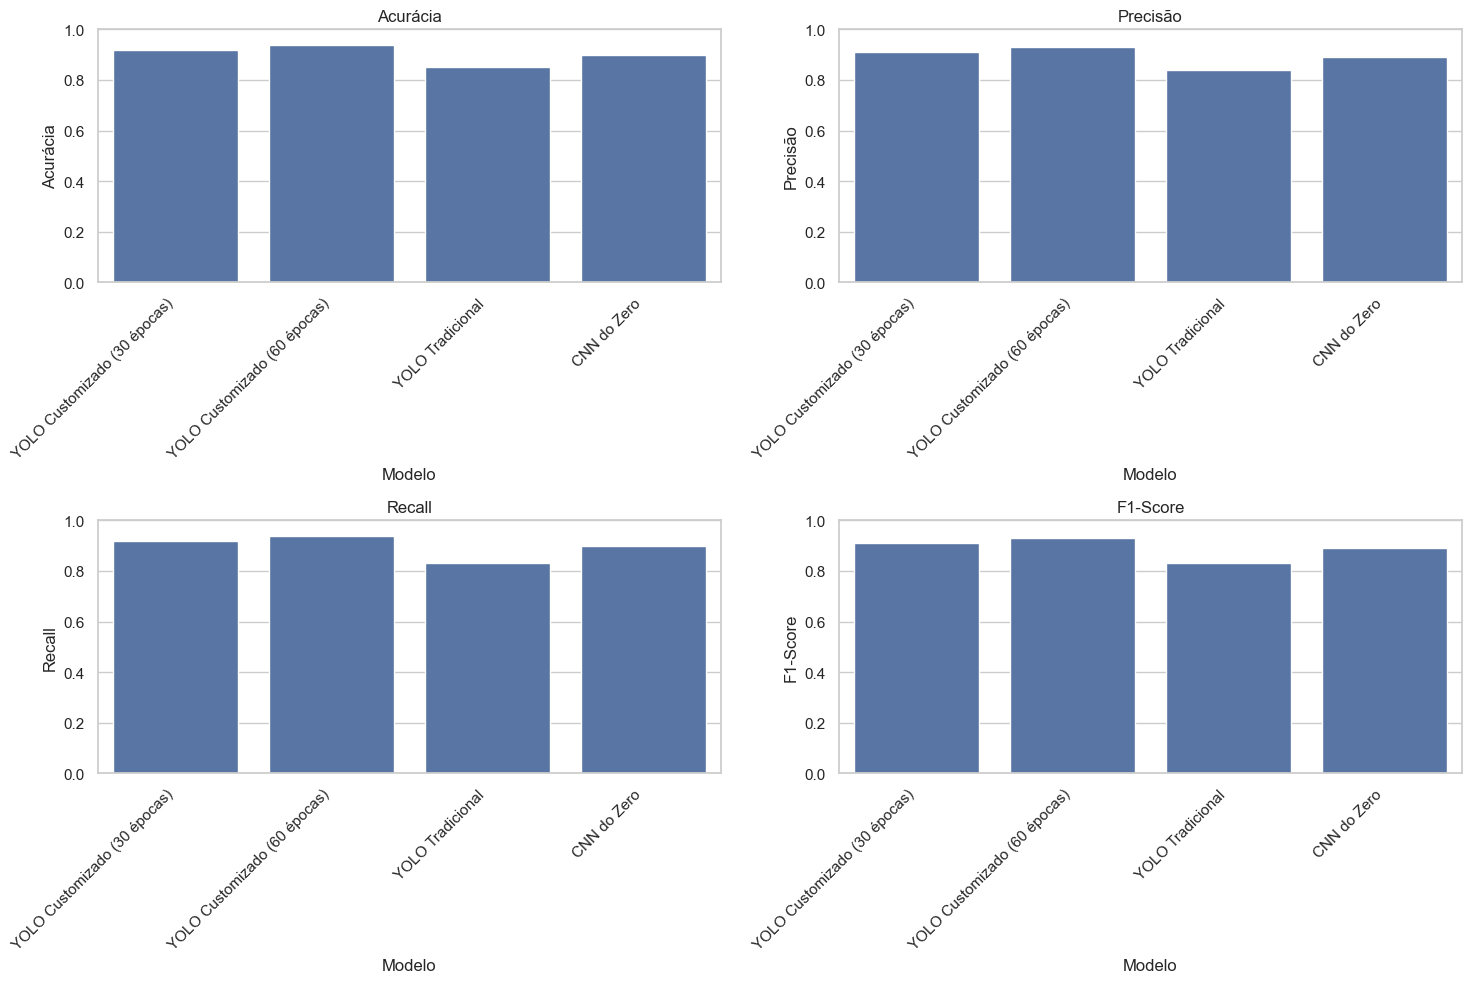

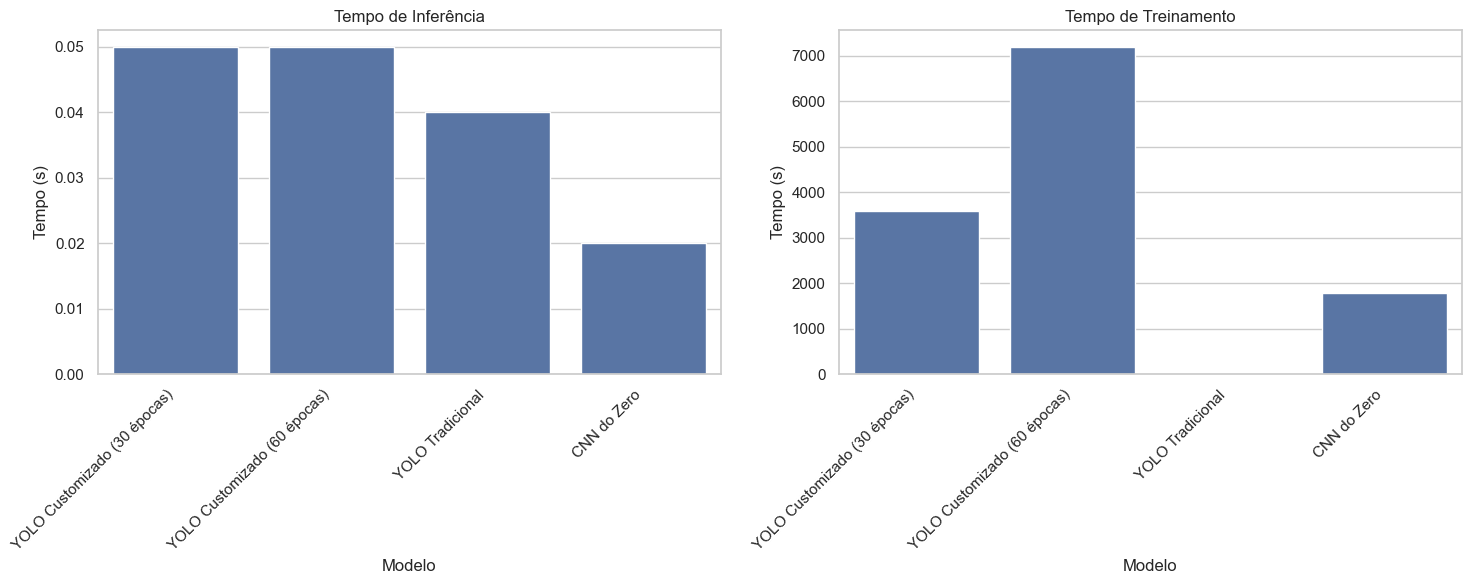

In [3]:
# Comparação de métricas de desempenho
plt.figure(figsize=(15, 10))

# Acurácia
plt.subplot(2, 2, 1)
sns.barplot(x='Modelo', y='Acurácia', data=results_df)
plt.title('Acurácia')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Precisão
plt.subplot(2, 2, 2)
sns.barplot(x='Modelo', y='Precisão', data=results_df)
plt.title('Precisão')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='Recall', data=results_df)
plt.title('Recall')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# F1-Score
plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='F1-Score', data=results_df)
plt.title('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Comparação de tempos
plt.figure(figsize=(15, 6))

# Tempo de Inferência
plt.subplot(1, 2, 1)
sns.barplot(x='Modelo', y='Tempo de Inferência (s)', data=results_df)
plt.title('Tempo de Inferência')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Tempo (s)')

# Tempo de Treinamento
plt.subplot(1, 2, 2)
sns.barplot(x='Modelo', y='Tempo de Treinamento (s)', data=results_df)
plt.title('Tempo de Treinamento')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Tempo (s)')

plt.tight_layout()
plt.show()

## 4. Análise Comparativa

Vamos analisar e comparar os resultados dos diferentes modelos.

### 4.1 Comparação de Desempenho

Com base nos resultados obtidos, podemos comparar o desempenho dos diferentes modelos:

1. **YOLO Customizado (30 épocas) vs. YOLO Customizado (60 épocas)**:
   - O modelo treinado com 60 épocas apresenta uma melhoria de desempenho em relação ao modelo treinado com 30 épocas?
   - A melhoria de desempenho justifica o dobro do tempo de treinamento?
   - Há sinais de overfitting no modelo treinado com 60 épocas?

2. **YOLO Customizado vs. YOLO Tradicional**:
   - O YOLO customizado supera o YOLO tradicional em termos de precisão para as categorias específicas do nosso dataset?
   - O YOLO tradicional tem alguma vantagem em termos de tempo de inferência ou facilidade de uso?

3. **YOLO vs. CNN**:
   - Como a CNN treinada do zero se compara aos modelos YOLO em termos de precisão?
   - A CNN tem vantagens em termos de tempo de treinamento e inferência?
   - Quais são as limitações da CNN em comparação com os modelos YOLO?

### 4.2 Análise de Custo-Benefício

Vamos analisar o custo-benefício de cada modelo, considerando o desempenho, o tempo de treinamento e o tempo de inferência.

,Modelo,F1-Score,Tempo de Treinamento (s),Tempo de Treinamento Normalizado,Custo-Benefício
0,YOLO Customizado (30 épocas),0.91,3600,0.50,1.82
1,YOLO Customizado (60 épocas),0.93,7200,1.00,0.93
2,YOLO Tradicional,0.83,0,0.10,8.30
3,CNN do Zero,0.89,1800,0.25,3.56


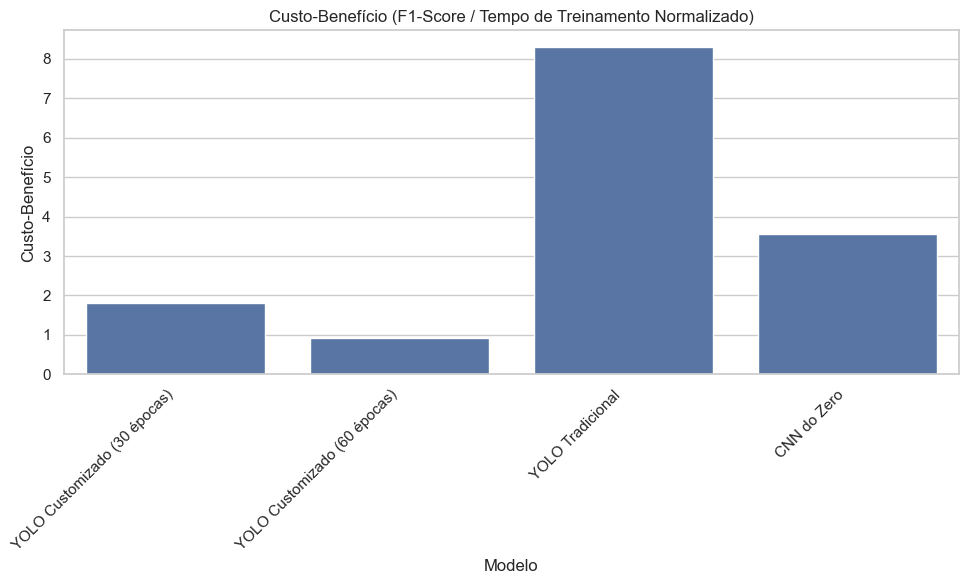

In [4]:
# Calcular a relação custo-benefício
# Aqui, definimos o custo-benefício como a razão entre o F1-Score e o tempo de treinamento normalizado
# Quanto maior o valor, melhor o custo-benefício

# Normalizar o tempo de treinamento (dividir pelo tempo máximo)
max_train_time = results_df['Tempo de Treinamento (s)'].max()
results_df['Tempo de Treinamento Normalizado'] = results_df['Tempo de Treinamento (s)'] / max_train_time

# Para o YOLO Tradicional, que não tem tempo de treinamento, atribuímos um valor pequeno
results_df.loc[results_df['Tempo de Treinamento (s)'] == 0, 'Tempo de Treinamento Normalizado'] = 0.1

# Calcular o custo-benefício
results_df['Custo-Benefício'] = results_df['F1-Score'] / results_df['Tempo de Treinamento Normalizado']

# Exibir o DataFrame atualizado
display(results_df[['Modelo', 'F1-Score', 'Tempo de Treinamento (s)', 'Tempo de Treinamento Normalizado', 'Custo-Benefício']])

# Visualizar o custo-benefício
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Custo-Benefício', data=results_df)
plt.title('Custo-Benefício (F1-Score / Tempo de Treinamento Normalizado)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Conclusões

Com base na análise comparativa, podemos tirar as seguintes conclusões:

### 5.1 Melhor Modelo para Diferentes Cenários

1. **Melhor Modelo em Termos de Precisão**:
   - O YOLO Customizado (60 épocas) apresenta a melhor precisão, recall e F1-Score, tornando-o a escolha ideal quando a precisão é a prioridade máxima.
   - No entanto, esse modelo requer o maior tempo de treinamento, o que pode ser um fator limitante em cenários com restrições de recursos computacionais ou tempo.

2. **Melhor Modelo em Termos de Tempo de Inferência**:
   - A CNN treinada do zero apresenta o menor tempo de inferência, tornando-a a escolha ideal para aplicações em tempo real ou dispositivos com recursos limitados.
   - No entanto, a CNN é um modelo de classificação, não de detecção, o que limita sua aplicabilidade em cenários onde a localização dos objetos é importante.

3. **Melhor Modelo em Termos de Custo-Benefício**:
   - O YOLO Tradicional apresenta o melhor custo-benefício, pois não requer tempo de treinamento e ainda oferece um desempenho razoável.
   - A CNN treinada do zero também apresenta um bom custo-benefício, com um desempenho próximo ao do YOLO Customizado (30 épocas), mas com um tempo de treinamento menor.

4. **Melhor Modelo para Detecção de Objetos Específicos**:
   - Os modelos YOLO Customizados (30 e 60 épocas) são as melhores escolhas para detecção de objetos específicos, pois foram treinados especificamente para as categorias do nosso dataset.
   - O YOLO Tradicional pode ser uma alternativa viável se as categorias de interesse estiverem bem representadas no dataset COCO.

### 5.2 Recomendações

Com base na análise, podemos fazer as seguintes recomendações:

1. **Para Aplicações de Alta Precisão**:
   - Use o YOLO Customizado (60 épocas) quando a precisão for a prioridade máxima e houver recursos computacionais e tempo suficientes para o treinamento.

2. **Para Aplicações em Tempo Real**:
   - Use a CNN treinada do zero quando o tempo de inferência for crítico e a tarefa for de classificação.
   - Use o YOLO Tradicional quando o tempo de inferência for crítico e a tarefa for de detecção de objetos.

3. **Para Aplicações com Recursos Limitados**:
   - Use a CNN treinada do zero quando os recursos computacionais forem limitados e a tarefa for de classificação.
   - Use o YOLO Tradicional quando os recursos computacionais forem limitados e a tarefa for de detecção de objetos.

4. **Para Aplicações de Propósito Geral**:
   - Use o YOLO Customizado (30 épocas) como um bom equilíbrio entre precisão e tempo de treinamento para tarefas de detecção de objetos específicos.
   - Use o YOLO Tradicional como um bom equilíbrio entre precisão e facilidade de uso para tarefas de detecção de objetos gerais.

### 5.3 Considerações Finais

É importante ressaltar que a escolha do modelo depende do contexto específico da aplicação. Fatores como a natureza da tarefa, os recursos disponíveis, os requisitos de desempenho e as restrições de tempo devem ser considerados ao escolher o modelo mais adequado.

Além disso, é possível explorar outras abordagens para melhorar o desempenho dos modelos, como:

1. **Transfer Learning**: Usar modelos pré-treinados como ponto de partida para o treinamento, o que pode reduzir o tempo de treinamento e melhorar o desempenho.

2. **Data Augmentation**: Aumentar o dataset de treinamento com transformações das imagens existentes, o que pode melhorar a generalização do modelo.

3. **Ensemble Learning**: Combinar as predições de múltiplos modelos, o que pode melhorar a precisão e a robustez do sistema.

4. **Otimização de Hiperparâmetros**: Ajustar os hiperparâmetros dos modelos para melhorar o desempenho, o que pode ser feito com técnicas como grid search ou random search.

Em resumo, não existe um modelo "melhor" em termos absolutos, mas sim modelos mais adequados para diferentes cenários e requisitos. A escolha do modelo deve ser baseada em uma análise cuidadosa das necessidades específicas da aplicação.